## Import libraries

In [3]:
# !pip install optuna
# !pip install catboost
# !pip install shap
# !pip install hrv-analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import warnings
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, auc, roc_curve
from catboost import CatBoostClassifier, Pool
import shap
from sklearn.metrics import f1_score
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values, get_time_domain_features
warnings.filterwarnings("ignore")
%matplotlib inline

- `train.csv` обучающая выборка со следующими столбцами:  
   - **id** - идентификатор временного ряда сердечного ритма
   - **time** - время в ms ( миллисекунды)
   - **x** - R-R интервал
   - **y** - признак разметки ковидной аномалии

In [100]:
df = pd.read_csv('train.csv')

In [101]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

In [102]:
# Train - Val - Test split
df.sort_values(by=['id', 'time'], inplace=True)

df_train = df[df.id<175].copy()
df_val = df[(df.id>=175) & (df.id<225)]
df_test = df[df.id>=225].copy()
df_train.shape, df_val.shape, df_test.shape

((43306, 4), (8872, 4), (8309, 4))

## Feature engeneering

In [103]:
# Обнаружение аномалий, накопительное среднее
def anomaly_detected(df):
  df['peak'] = 0
  res = pd.DataFrame()
  for i in df.id.unique():
    df.loc[detect_peaks(df[df.id==i]['x'], threshold=0.3)[0], 'peak']=1
    df.loc[(df.id==i),'peak2'] = detect_peaks(df[df.id==i]['x'], threshold=0.3)[1]
  new_df = pd.DataFrame()
  for i in df.id.unique():
    new_df_tmp = pd.concat([df[df.id==i].merge(
        pd.DataFrame(remove_outliers(df[df.id==i]['x'], verbose = False), columns=['anomaly_1']),
                    on = np.arange(len(df[df.id==i]))).drop(['key_0'], axis=1)])
    new_df = pd.concat([new_df, new_df_tmp])
  new_df2 = pd.DataFrame()
  for i in df.id.unique():
    new_df2_tmp = pd.concat([df[df.id==i].merge(
        pd.DataFrame(remove_ectopic_beats(list(df[df.id==i]['x']), verbose = False), columns=['anomaly_2']),
                    on = np.arange(len(df[df.id==i]))).drop(['key_0'], axis=1)])
    new_df2 = pd.concat([new_df2, new_df2_tmp])
  new_df['anomaly__1'] = (new_df['anomaly_1'].isnull()).astype(int)
  new_df2['anomaly__2'] = (new_df2['anomaly_2'].isnull()).astype(int)
  new_df.drop(['anomaly_1'], axis=1, inplace=True)
  new_df2.drop(['anomaly_2'], axis=1, inplace=True)
  df = new_df.merge(new_df2[['id', 'time', 'anomaly__2']], on = ['id', 'time'])
  df['EMA'] = df['x'].ewm(span=40,adjust=False).mean()
  df['one'] = 1
  df['x_cummean'] = df.groupby(['id'])['x'].cumsum() / df.groupby(['id'])['one'].cumsum()
  df['peak_cummean'] = df.groupby(['id'])['peak'].cumsum() / df.groupby(['id'])['one'].cumsum()
  df['is_anomaly'] = df['anomaly__1'] + df['anomaly__2']
  df.drop(['one'], axis=1, inplace=True)
  return df

In [104]:
# Накопительное среднее без аномалий, фичи по количеству аномалий
def first_prepr(df_train, delete_anomaly = True):
    df_train.sort_values(by=['id', 'time'], inplace=True)
    df_train['anomaly1_cumsum'] = df_train.groupby(['id'])['anomaly__1'].cumsum()
    df_train['anomaly2_cumsum'] = df_train.groupby(['id'])['anomaly__2'].cumsum()
    df_train['one'] = 1
    # Номер итерации
    df_train['num_iter'] = df.groupby(['id']).cumcount()+1    
    df_train['norm_x'] = 60000 / df_train['x']
    df_train = df_train.merge(df_train.groupby(['id'])['norm_x'].mean().to_frame('norm_mean_value'),
                                                      left_on = ['id'], right_index=True)
    df_train = df_train.merge(df_train.groupby(['id'])['x'].mean().to_frame('mean_value'),
                                                      left_on = ['id'], right_index=True)\
        .merge(df_train.groupby(['id'])['x'].std().to_frame('std_value'), left_on = ['id'], right_index=True)\
            .merge(df_train.groupby(['id'])['x'].min().to_frame('min_value'), left_on = ['id'], right_index=True)\
                    .merge(df_train.groupby(['id'])['x'].max().to_frame('max_value'), left_on = ['id'], right_index=True)\
              .merge(df_train[df_train.is_anomaly==0].groupby(['id'])['x'].mean().to_frame('mean_not_anomaly'), 
                     left_on=['id'], right_index=True, how='left').\
              merge(df_train[df_train.is_anomaly==0].groupby(['id'])['x'].cumsum().to_frame('cumsum_wo_anomaly'), 
                     left_index =True, right_index=True, how='left').\
              merge(df_train[df_train.is_anomaly==0].groupby(['id'])['one'].cumsum().to_frame('cumcount_wo_anomaly'), 
                     left_index =True, right_index=True, how='left')
    df_train['cummean_wo_anomaly'] = df_train['cumsum_wo_anomaly'] / df_train['cumcount_wo_anomaly']
    for i in range(100):
      if df_train.cummean_wo_anomaly.isnull().sum()>0:
        df_train['cummean_wo_anomaly_sh_1'] = df_train['cummean_wo_anomaly'].shift(1)
        df_train.loc[df_train.cummean_wo_anomaly.isnull(), 'cummean_wo_anomaly'] = \
              df_train.loc[df_train.cummean_wo_anomaly.isnull(), 'cummean_wo_anomaly_sh_1']
    df_train['cummean_diff'] = df_train['cummean_wo_anomaly'] / df_train['x_cummean']
    df_train['not_anomaly_perc'] = df_train['cumcount_wo_anomaly'] / df_train['num_iter']
    df_train.drop(['cummean_wo_anomaly_sh_1', 'one', 'cumcount_wo_anomaly'], axis=1, inplace=True)
    
    if delete_anomaly:
      df_train = df_train[df_train.anomaly__1==0]
    return df_train

In [105]:
# Куча фичей
def feature_generate(df_train):  
    df_train['peak_new'] = 0
    res = pd.DataFrame()
    for i in df_train.id.unique():
      df_train.loc[detect_peaks(df_train[df_train.id==i]['x'], threshold=0.3)[0], 'peak_new']=1
      df_train.loc[(df_train.id==i),'peak_new2'] = detect_peaks(df_train[df_train.id==i]['x'], threshold=0.3)[1]
    for n in tqdm_notebook([1,2,3,5,10,25,50,100,250,500, 10000]):
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n).mean().to_frame(f'mean_rolling_{n}'),
               on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['norm_x'].rolling(window=n, min_periods=1).mean()\
                                  .to_frame(f'norm_mean_rolling_1_{n}'),
                                  on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n).std().to_frame(f'std_rolling_{n}'),
               on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['norm_x'].rolling(window=n, min_periods=1)\
                                    .std().to_frame(f'norm_std_rolling_1_{n}'),
               on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)

        indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=n)
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(
            window=indexer, min_periods=1).mean().to_frame(f'mean_rolling_1_{n}_f'),
               on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        if n >=100:
          df_train = df_train.merge(df_train.groupby(['id'])['peak'].rolling(window=n, min_periods=1, center=True).sum()\
                                  .to_frame(f'peak_sum_c_1_rolling_{n}'),
                                  on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
          df_train = df_train.merge(df_train.groupby(['id'])['peak'].rolling(window=n, min_periods=1, center=True).mean()\
                                  .to_frame(f'peak_mean_c_1_rolling_{n}'),
                                  on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
          df_train = df_train.merge(df_train.groupby(['id'])['peak_new'].rolling(window=n, min_periods=1, center=True).sum()\
                                  .to_frame(f'peak_new_sum_c_1_rolling_{n}'),
                                  on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
          df_train = df_train.merge(df_train.groupby(['id'])['peak_new'].rolling(window=n, min_periods=1, center=True).mean()\
                                  .to_frame(f'peak_new_mean_c_1_rolling_{n}'),
                                  on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)

        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(
            window=n, min_periods=1, center=True).mean().to_frame(f'mean_rolling_1_{n}_c'),
               on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['norm_x'].rolling(
            window=n, min_periods=1, center=True).mean().to_frame(f'norm_mean_rolling_1_{n}_c'),
               on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(
            window=n, min_periods=1, center=True).std().to_frame(f'std_rolling_{n}_c'),
               on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['norm_x'].rolling(
            window=n, min_periods=1, center=True).std().to_frame(f'norm_std_rolling_{n}_c'),
               on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n, min_periods=1)\
            .max().to_frame(f'max_rolling_1_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n, min_periods=1, center=True)\
            .max().to_frame(f'max_rolling_1_{n}_c'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n, min_periods=1, center=True)\
            .min().to_frame(f'min_rolling_1_{n}_c'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train[f'max_rolling_1_{n}_rel1'] = df_train[f'max_rolling_1_{n}'] / df_train[f'mean_value']
        df_train[f'max_rolling_1_{n}_rel2'] = df_train[f'max_rolling_1_{n}'] / df_train[f'max_value']
        df_train[f'max_rolling_1_{n}_rel3'] = df_train[f'max_rolling_1_{n}'] / df_train[f'min_value']
        df_train[f'max_rolling_1_{n}_rel4'] = df_train[f'max_rolling_1_{n}'] / df_train[f'cummean_wo_anomaly']
        df_train[f'max_rolling_1_{n}_rel5'] = df_train[f'max_rolling_1_{n}'] / df_train[f'EMA']
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n, min_periods=1)\
            .mean().to_frame(f'mean_rolling_1_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['anomaly__1'].rolling(window=n, min_periods=1)\
            .mean().to_frame(f'mean_rolling_new_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['anomaly__2'].rolling(window=n, min_periods=1)\
            .mean().to_frame(f'mean_rolling_new2_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train[f'mean_rolling_1_{n}_rel1'] = df_train[f'mean_rolling_1_{n}'] / df_train[f'mean_value']
        df_train[f'mean_rolling_1_{n}_rel2'] = df_train[f'mean_rolling_1_{n}'] / df_train[f'max_value']
        df_train[f'mean_rolling_{n}_rel1_c'] = df_train[f'mean_rolling_1_{n}_c'] / df_train[f'mean_value']
        df_train[f'mean_rolling_{n}_rel2_c'] = df_train[f'mean_rolling_1_{n}_c'] / df_train[f'max_value']
        df_train[f'mean_rolling_{n}_rel1_f'] = df_train[f'mean_rolling_1_{n}_f'] / df_train[f'mean_value']
        df_train[f'mean_rolling_{n}_rel2_f'] = df_train[f'mean_rolling_1_{n}_f'] / df_train[f'max_value']
        df_train[f'mean_rolling_1_{n}_rel3'] = df_train[f'mean_rolling_1_{n}'] / df_train[f'min_value']
        df_train[f'mean_rolling_1_{n}_rel4'] = df_train[f'mean_rolling_1_{n}'] / df_train[f'cummean_wo_anomaly']
        df_train[f'mean_rolling_1_{n}_rel5'] = df_train[f'mean_rolling_1_{n}'] / df_train[f'EMA']
        df_train[f'norm_mean_rolling_1_{n}_rel1'] = df_train[f'norm_mean_rolling_1_{n}'] / df_train[f'mean_value']
        df_train[f'norm_mean_rolling_1_{n}_rel2'] = df_train[f'norm_mean_rolling_1_{n}'] / df_train[f'max_value']
        df_train[f'norm_mean_rolling_1_{n}_rel3'] = df_train[f'norm_mean_rolling_1_{n}'] / df_train[f'min_value']
        df_train[f'norm_mean_rolling_1_{n}_rel4'] = df_train[f'norm_mean_rolling_1_{n}'] / df_train[f'cummean_wo_anomaly']
        df_train[f'norm_mean_rolling_1_{n}_rel5'] = df_train[f'norm_mean_rolling_1_{n}'] / df_train[f'EMA']
        df_train[f'norm_mean_rolling_1_{n}_rel5'] = df_train[f'norm_mean_rolling_1_{n}'] / df_train[f'norm_mean_value']
       
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n, min_periods=1)\
            .min().to_frame(f'min_rolling_1_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train[f'min_rolling_1_{n}_rel1'] = df_train[f'min_rolling_1_{n}'] / df_train[f'mean_value']
        df_train[f'min_rolling_1_{n}_rel2'] = df_train[f'min_rolling_1_{n}'] / df_train[f'max_value']
        df_train[f'min_rolling_1_{n}_rel3'] = df_train[f'min_rolling_1_{n}'] / df_train[f'min_value']
        df_train[f'min_rolling_1_{n}_rel4'] = df_train[f'min_rolling_1_{n}'] / df_train[f'cummean_wo_anomaly']
        df_train[f'min_rolling_1_{n}_rel5'] = df_train[f'min_rolling_1_{n}'] / df_train[f'EMA']
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n, min_periods=1)\
            .median().to_frame(f'median_rolling_1_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n, min_periods=1, center=True)\
            .median().to_frame(f'median_rolling_1_{n}_c'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train[f'median_rolling_1_{n}_rel1'] = df_train[f'median_rolling_1_{n}'] / df_train[f'mean_value']
        df_train[f'median_rolling_1_{n}_rel2'] = df_train[f'median_rolling_1_{n}'] / df_train[f'max_value']
        df_train[f'median_rolling_1_{n}_rel3'] = df_train[f'median_rolling_1_{n}'] / df_train[f'min_value']
        df_train[f'median_rolling_1_{n}_rel4'] = df_train[f'median_rolling_1_{n}'] / df_train[f'cummean_wo_anomaly']
        df_train[f'median_rolling_1_{n}_rel5'] = df_train[f'median_rolling_1_{n}'] / df_train[f'EMA']
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n, min_periods=1)\
            .std().to_frame(f'std_rolling_1_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)        
        df_train[f'std_rolling_1_{n}_rel1'] = df_train[f'std_rolling_1_{n}'] / df_train[f'std_value']
        df_train[f'std_rolling_1_{n}_rel2'] = df_train[f'std_rolling_1_{n}'] / df_train[f'mean_value']
        df_train[f'std_rolling_1_{n}_rel3'] = df_train[f'std_rolling_1_{n}'] / df_train[f'cummean_wo_anomaly']
        df_train[f'std_rolling_1_{n}_rel4'] = df_train[f'std_rolling_1_{n}'] / df_train[f'EMA']       
        df_train[f'norm_std_rolling_1_{n}_rel1'] = df_train[f'norm_std_rolling_1_{n}'] / df_train[f'std_value']
        df_train[f'norm_std_rolling_1_{n}_rel2'] = df_train[f'norm_std_rolling_1_{n}'] / df_train[f'mean_value']
        df_train[f'norm_std_rolling_1_{n}_rel3'] = df_train[f'norm_std_rolling_1_{n}'] / df_train[f'cummean_wo_anomaly']
        df_train[f'norm_std_rolling_1_{n}_rel4'] = df_train[f'norm_std_rolling_1_{n}'] / df_train[f'EMA']

        df_train[f'up_anomaly_{n}'] = (df_train['x'] > df_train[f'mean_rolling_1_{n}_rel3'] + \
                                        df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'up_anomaly2_{n}'] = (df_train['x'] > df_train[f'mean_rolling_1_{n}_rel3'] + \
                                        2* df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'up_anomaly3_{n}'] = (df_train['x'] > df_train[f'mean_rolling_1_{n}_rel3'] + \
                                        3 * df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'down_anomaly_{n}'] = (df_train['x'] < df_train[f'mean_rolling_1_{n}_rel3'] - \
                                        df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'down_anomaly2_{n}'] = (df_train['x'] < df_train[f'mean_rolling_1_{n}_rel3'] - \
                                        2*df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'down_anomaly3_{n}'] = (df_train['x'] < df_train[f'mean_rolling_1_{n}_rel3'] - \
                                       3* df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'is_anomaly_{n}'] = df_train[f'up_anomaly_{n}'] + df_train[f'up_anomaly2_{n}'] + \
          df_train[f'up_anomaly3_{n}'] + df_train[f'down_anomaly_{n}'] + df_train[f'down_anomaly2_{n}'] + \
            df_train[f'down_anomaly3_{n}']

        df_train[f'4up_anomaly_{n}'] = (df_train['x'] > df_train[f'mean_rolling_1_{n}_rel4'] + \
                                        df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'4up_anomaly2_{n}'] = (df_train['x'] > df_train[f'mean_rolling_1_{n}_rel4'] + \
                                        2* df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'4up_anomaly3_{n}'] = (df_train['x'] > df_train[f'mean_rolling_1_{n}_rel4'] + \
                                        3 * df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'4down_anomaly_{n}'] = (df_train['x'] < df_train[f'mean_rolling_1_{n}_rel4'] - \
                                        df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'4down_anomaly2_{n}'] = (df_train['x'] < df_train[f'mean_rolling_1_{n}_rel4'] - \
                                        2*df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'4down_anomaly3_{n}'] = (df_train['x'] < df_train[f'mean_rolling_1_{n}_rel4'] - \
                                       3* df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'4is_anomaly_{n}'] = df_train[f'4up_anomaly_{n}'] + df_train[f'4up_anomaly2_{n}'] + \
          df_train[f'4up_anomaly3_{n}'] + df_train[f'4down_anomaly_{n}'] + df_train[f'4down_anomaly2_{n}'] + \
            df_train[f'4down_anomaly3_{n}']        
    df_train['strange_x1'] = df_train['x'] / df_train[f'mean_value']
    df_train['strange_x2'] = df_train['x'] / df_train[f'cummean_wo_anomaly']
    df_train['strange_x3'] = df_train['x'] / df_train[f'x_cummean']
    df_train['strange_x4'] = df_train['x'] / df_train[f'EMA']
    df_train['strange_x5'] = df_train['x'] / df_train[f'mean_rolling_5']
    df_train['strange_x6'] = df_train['x'] / df_train[f'mean_rolling_100']
    df_train.num_iter = (df_train.num_iter//100)
    df_train['less066'] = (df_train['x'] / df_train['cummean_wo_anomaly'] <0.66).astype(int)
    df_train['more133'] = (df_train['x'] / df_train['cummean_wo_anomaly'] >1.33).astype(int)

    df_train = df_train.merge(
    (df_train.groupby(['id'])['time'].max() / 60000).astype(int).to_frame('mins'),
    left_on = 'id', right_index=True)
    
    df_train = df_train.merge(
    (df_train.groupby(['id'])['time'].max()).astype(int).to_frame('max_time'),
    left_on = 'id', right_index=True)
    df_train['time_share'] = df_train['time'] / df_train['max_time']

    df_train = df_train.merge(
        (df_train.groupby(['id'])['time'].max() / 1000).astype(int).to_frame('secs'),
        left_on = 'id', right_index=True)

    df_train['anomaly_feat'] = df_train['max_rolling_1_10000'] / df_train['median_rolling_1_10000']
    df_train['anomaly_feat3'] = df_train['max_rolling_1_3'] / df_train['median_rolling_1_10']
    df_train['std_diff'] = df_train['std_rolling_10_c'] / df_train['norm_std_rolling_10_c']

    df_train['my_feat1'] = abs(df_train['max_rolling_1_10'] / df_train[f'median_rolling_1_250']) + abs(df_train['min_rolling_1_10'] / df_train[f'median_rolling_1_250'])
    df_train['my_feat2'] = abs(df_train['max_rolling_1_3'] / df_train[f'median_rolling_1_250']) +  abs(df_train['min_rolling_1_3'] / df_train[f'median_rolling_1_250'])
    df_train['my_feat3'] = abs(df_train['max_rolling_1_10_c'] / df_train[f'median_rolling_1_250']) + abs(df_train['min_rolling_1_10_c'] / df_train[f'median_rolling_1_250'])
    df_train['my_feat4'] = abs(df_train['max_rolling_1_10_c'] / df_train[f'median_rolling_1_250_c']) + abs(df_train['min_rolling_1_10_c'] / df_train[f'median_rolling_1_250_c'])
    return df_train

In [106]:
df_train = anomaly_detected(df_train)
df_val = anomaly_detected(df_val)
df_test = anomaly_detected(df_test)
print(df_train.shape)

(43306, 12)


In [107]:
df_train.groupby(['anomaly__1'])['y'].agg(['count', 'sum', 'mean'])

,count,sum,mean
anomaly__1,,,
0,38146,5849,0.153332
1,5160,0,0.000000


In [108]:
df_train = first_prepr(df_train)
df_val = first_prepr(df_val)
df_test = first_prepr(df_test)

In [109]:
df_train = df_train[df_train.x<1100]
df_val = df_val[df_val.x<1100]
df_test = df_test[df_test.x<1100]

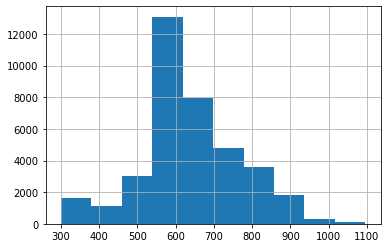

In [110]:
df_train['x'].hist()

In [111]:
df_train = feature_generate(df_train)
df_val = feature_generate(df_val)
df_test = feature_generate(df_test)

In [120]:
df_train = pd.read_pickle('df_train')
df_val = pd.read_pickle('df_val')
df_test = pd.read_pickle('df_test')

In [121]:
from hrvanalysis import get_sampen, get_time_domain_features, get_geometrical_features, get_frequency_domain_features,\
 get_csi_cvi_features, get_poincare_plot_features

In [122]:
def new_feats(df_train):
  get_sampen_df_res = pd.DataFrame()
  get_time_domain_features_res = pd.DataFrame()
  get_geometrical_features_res = pd.DataFrame()
  get_frequency_domain_features_res = pd.DataFrame()
  get_csi_cvi_features_res = pd.DataFrame()
  get_poincare_plot_features_res = pd.DataFrame()
  for i in df_train.id.unique():
    get_sampen_df =  pd.DataFrame(get_sampen(df_train[df_train.id==i]['x']), index=[i])
    get_sampen_df['id'] = i 
    get_sampen_df_res = pd.concat([get_sampen_df, get_sampen_df_res])
    get_time_domain_features_df =  pd.DataFrame(get_time_domain_features(df_train[df_train.id==i]['x']), index=[i])
    get_time_domain_features_df['id'] = i 
    get_time_domain_features_res = pd.concat([get_time_domain_features_df, get_time_domain_features_res])
    get_geometrical_features_df =  pd.DataFrame(get_geometrical_features(df_train[df_train.id==i]['x']), index=[i])
    get_geometrical_features_df['id'] = i 
    get_geometrical_features_res = pd.concat([get_geometrical_features_df, get_geometrical_features_res])
    get_frequency_domain_features_df =  pd.DataFrame(get_frequency_domain_features(df_train[df_train.id==i]['x']), index=[i])
    get_frequency_domain_features_df['id'] = i 
    get_frequency_domain_features_res = pd.concat([get_frequency_domain_features_df, get_frequency_domain_features_res])
    get_csi_cvi_features_df =  pd.DataFrame(get_csi_cvi_features(df_train[df_train.id==i]['x']), index=[i])
    get_csi_cvi_features_df['id'] = i 
    get_csi_cvi_features_res = pd.concat([get_csi_cvi_features_df, get_csi_cvi_features_res])
    get_poincare_plot_features_df =  pd.DataFrame(get_poincare_plot_features(df_train[df_train.id==i]['x']), index=[i])
    get_poincare_plot_features_df['id'] = i 
    get_poincare_plot_features_res = pd.concat([get_poincare_plot_features_df, get_poincare_plot_features_res])
  df_train = df_train.merge(get_sampen_df_res, on=['id'])
  df_train = df_train.merge(get_time_domain_features_res, on=['id'])
  df_train = df_train.merge(get_geometrical_features_res, on=['id'])
  df_train = df_train.merge(get_frequency_domain_features_res, on=['id'])
  df_train = df_train.merge(get_csi_cvi_features_res, on=['id'])
  df_train = df_train.merge(get_poincare_plot_features_res, on=['id'])
  return df_train
  
df_train = new_feats(df_train)
df_val = new_feats(df_val)
df_test = new_feats(df_test)

In [123]:
df_val.shape

(7801, 865)

In [124]:
df_train['change'] = df_train['x'] / df_train['median_rolling_1_100']
df_val['change'] = df_val['x'] / df_val['median_rolling_1_100']
df_test['change'] = df_test['x'] / df_test['median_rolling_1_100']

df_train.groupby(['y'])['change'].agg(['max', 'min'])

,max,min
y,,
0,2.944444,0.327660
1,2.163793,0.814208


In [126]:
df_train[df_train.change>2.15]['y'].count()

100

In [129]:
# df_train = df_train[df_train['change']<2.15]
# df_val = df_val[df_val['change']<2.15]
# df_test = df_test[df_test['change']<2.15]


df_train = df_train[df_train['change']>0.8]
df_val = df_val[df_val['change']>0.8]
df_test = df_test[df_test['change']>0.8]

In [128]:
# df_train.groupby(['less066'])['y'].agg(['count', 'sum', 'mean'])

,count,sum,mean
less066,,,
0,36023,5845,0.162257
1,1487,4,0.002690


In [ ]:
# df_train = df_train[df_train.less066==0]
# df_val = df_val[df_val.less066==0]
# df_test = df_test[df_test.less066==0]

In [130]:
df_train.shape, df_val.shape, df_test.shape

((35678, 866), (7115, 866), (6952, 866))

In [131]:
df_train['y'].agg(['mean', 'sum'])

mean       0.163939
sum     5849.000000
Name: y, dtype: float64

In [ ]:
# res = pd.DataFrame()
# for i in df_train.columns:
#   res = pd.concat([res, pd.DataFrame({'col': i, 'val':df_val[df_val.y==1][i].mean(),
#               'test':df_test[df_test.y==1][i].mean()}, index=[i])])
# res['diff'] = (res['test'] - res['val']) / res['val']
# bads = list(res[(res['diff']>0.15) | (res['diff']<-0.15)].index)

In [ ]:
# mycols = []
# for i in df_train.columns:
#   if i not in bads and i not in (['id', 'y']):
#     mycols.append(i)

In [ ]:
# len(bads)

169

## Обучений моделей, подбор фичей и параметров

In [132]:
train_pool = Pool(df_train.drop(['y', 'id'], axis=1), df_train['y'])
val_pool = Pool(df_val.drop(['y', 'id'], axis=1), df_val['y'])
test_pool = Pool(df_test.drop(['y', 'id'], axis=1), df_test['y'])

In [133]:
y_train = df_train['y']
y_val = df_val['y']

In [134]:
def objective(trial): 
    param = {                 
            'depth' : trial.suggest_int('max_depth',1,7),
            'n_estimators':  trial.suggest_int("n_estimators", 100, 1000),
            'l2_leaf_reg': trial.suggest_uniform("reg_lambda", 0, 100),
            'learning_rate' : trial.suggest_loguniform('learning_rate',0.01,0.1),
            'border_count': trial.suggest_int("border_count", 1, 255),
            'random_strength' : trial.suggest_loguniform('random_strength', 1e-9, 10),
            'bagging_temperature': trial.suggest_uniform("bagging_temperature", 0, 1),
        'task_type': 'GPU',
        "loss_function":'Logloss', 
        'random_state':123,
        "verbose": False
    }
    
    cb = CatBoostClassifier(**param)
    cb.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=0)
    
    train_auc = roc_auc_score(y_train, cb.predict_proba(train_pool)[:,1])
    test_auc = roc_auc_score(y_val, cb.predict_proba(val_pool)[:,1])
    print(f"TRAIN GINI = {2*train_auc-1}")
    print(f"Validate GINI = {2*test_auc-1}")
    res_val = []
    res_train = []
    res_test = []
    for i in np.linspace(0,1,50):
        res_val.append(f1_score(df_val['y'], cb.predict_proba(val_pool)[:,1]>i))
        res_train.append(f1_score(df_train['y'], cb.predict_proba(train_pool)[:,1]>i))
        res_test.append(f1_score(df_test['y'], cb.predict_proba(test_pool)[:,1]>i))
    print('f1 train = ', round(np.max(res_train), 4))
    print('f1 val = ', round(np.max(res_val), 4))
    print('f1 test = ', round(res_test[np.argmax(res_val)], 4))
    return np.max(res_val)#-train_auc + 10 * test_auc

In [ ]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective, n_trials=25)

[I 2021-06-18 16:05:08,953] A new study created in memory with name: no-name-41b7d67c-e947-43b9-961e-0ab25fbecf35
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

TRAIN GINI = 0.8471313774938218
Validate GINI = 0.754778263643564


[I 2021-06-18 16:05:15,353] Trial 0 finished with value: 0.6329658510352246 and parameters: {'max_depth': 1, 'n_estimators': 416, 'reg_lambda': 7.137248512333838, 'learning_rate': 0.0370784790074692, 'border_count': 246, 'random_strength': 6.718975652238964e-06, 'bagging_temperature': 0.27946960568384216}. Best is trial 0 with value: 0.6329658510352246.


f1 train =  0.7131
f1 val =  0.633
f1 test =  0.6281
TRAIN GINI = 0.9278582832252615
Validate GINI = 0.7872775973866861


[I 2021-06-18 16:05:30,148] Trial 1 finished with value: 0.6549568323905924 and parameters: {'max_depth': 5, 'n_estimators': 971, 'reg_lambda': 53.882832672932004, 'learning_rate': 0.09589764151725622, 'border_count': 242, 'random_strength': 0.003961173506581109, 'bagging_temperature': 0.15742842743579855}. Best is trial 1 with value: 0.6549568323905924.


f1 train =  0.799
f1 val =  0.655
f1 test =  0.656


KeyboardInterrupt: ignored

In [135]:
best_params =  {'max_depth': 7, 'n_estimators': 542, 'reg_lambda': 96.16297536454806, 'learning_rate': 0.03403866427000714,
                'border_count': 254, 'random_strength': 0.042446597740281575, 'bagging_temperature': 0.2823273503804664,
                       'task_type': 'GPU',
        "loss_function":'Logloss' ,
        'random_state':123}

In [136]:
cb = CatBoostClassifier(**best_params)
cb.fit(train_pool, eval_set=val_pool, verbose=100, early_stopping_rounds=50)

0:	learn: 0.6529691	test: 0.6614215	best: 0.6614215 (0)	total: 191ms	remaining: 1m 43s
100:	learn: 0.2055724	test: 0.3409646	best: 0.3409646 (100)	total: 18.9s	remaining: 1m 22s
200:	learn: 0.1775987	test: 0.3249909	best: 0.3248257 (199)	total: 37.3s	remaining: 1m 3s
300:	learn: 0.1572730	test: 0.3134385	best: 0.3134385 (300)	total: 55.9s	remaining: 44.7s
400:	learn: 0.1420578	test: 0.3093620	best: 0.3093620 (400)	total: 1m 14s	remaining: 26.2s
500:	learn: 0.1298875	test: 0.3049324	best: 0.3047603 (493)	total: 1m 33s	remaining: 7.62s
541:	learn: 0.1262731	test: 0.3044125	best: 0.3043576 (538)	total: 1m 40s	remaining: 0us
bestTest = 0.3043576099
bestIteration = 538
Shrink model to first 539 iterations.


In [137]:
res_val = []
res_train = []
res_test = []
for i in np.linspace(0,1,50):
    res_val.append(f1_score(df_val['y'], cb.predict_proba(val_pool)[:,1]>i))
    res_train.append(f1_score(df_train['y'], cb.predict_proba(train_pool)[:,1]>i))
    res_test.append(f1_score(df_test['y'], cb.predict_proba(test_pool)[:,1]>i))

In [138]:
print('f1 val = ', round(np.max(res_val), 4))
print('f1 test = ', round(res_test[np.argmax(res_val)], 4))
print(np.linspace(0,1,50)[np.argmax(res_val)])

f1 val =  0.6871
f1 test =  0.6718
0.2857142857142857


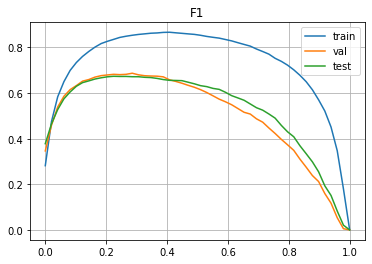

In [139]:
plt.title('F1')
plt.plot(np.linspace(0,1,50), res_train, label='train')
plt.plot(np.linspace(0,1,50), res_val, label='val')
plt.plot(np.linspace(0,1,50), res_test, label='test')
plt.legend()
plt.grid()

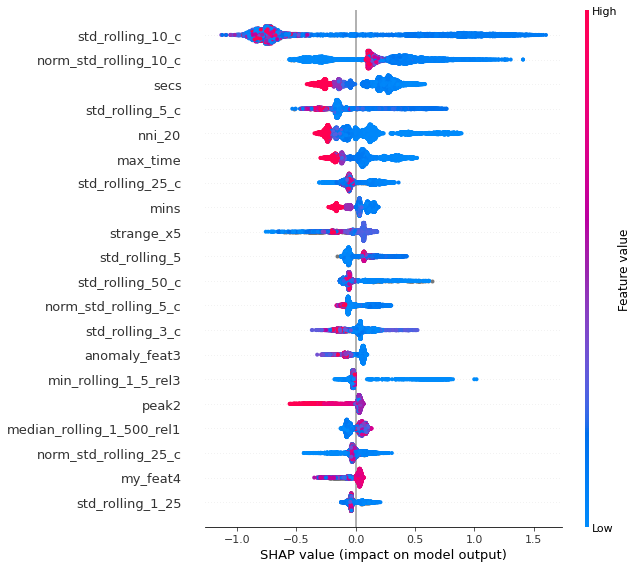

In [141]:
shap_values = cb.get_feature_importance(val_pool, type='ShapValues')[:,:-1]
shap.summary_plot(shap_values, df_val.drop(['id', 'y'], axis=1))

In [142]:
cb_imps = pd.DataFrame({'cols':list(df_val.drop(['id', 'y'], axis=1).columns), 
                        'imps': np.mean(np.abs(shap_values),axis=0)}).sort_values(by=['imps'], ascending=False)

In [145]:
new_cols = list(cb_imps[cb_imps.imps>0.02]['cols'])

In [146]:
len(new_cols)

48

In [147]:
new_cols

['std_rolling_10_c',
 'norm_std_rolling_10_c',
 'secs',
 'std_rolling_5_c',
 'nni_20',
 'max_time',
 'std_rolling_25_c',
 'mins',
 'strange_x5',
 'std_rolling_5',
 'std_rolling_50_c',
 'norm_std_rolling_5_c',
 'std_rolling_3_c',
 'anomaly_feat3',
 'min_rolling_1_5_rel3',
 'peak2',
 'median_rolling_1_500_rel1',
 'norm_std_rolling_25_c',
 'my_feat4',
 'std_rolling_1_25',
 'peak_mean_c_1_rolling_500',
 'std_rolling_1_50_rel3',
 'std_rolling_1_10',
 'std_rolling_1_10_rel3',
 'time',
 'std_rolling_1_25_rel3',
 'triangular_index',
 'anomaly2_cumsum',
 'norm_std_rolling_50_c',
 'peak_new2',
 'median_rolling_1_25_rel4',
 'median_rolling_1_50_rel5',
 'min_rolling_1_10000',
 'peak_sum_c_1_rolling_500',
 'norm_mean_rolling_1_25_rel4',
 'std_value',
 'max_rolling_1_5_rel2',
 'median_rolling_1_100_rel5',
 'time_share',
 'median_rolling_1_10000_rel4',
 'max_rolling_1_50_c',
 'std_rolling_1_5_rel3',
 'mean_rolling_1_50_f',
 'std_rolling_1_5',
 'peak_new_mean_c_1_rolling_100',
 'std_rolling_1_5_rel2',

In [148]:
train_pool = Pool(df_train[new_cols], df_train['y'])
val_pool = Pool(df_val[new_cols], df_val['y'])
test_pool = Pool(df_test[new_cols], df_test['y'])

In [ ]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective, n_trials=50)

[I 2021-06-18 16:15:39,970] A new study created in memory with name: no-name-7cfd3e53-9460-4c26-b09d-1c992f4945ef


TRAIN GINI = 0.869111903532624
Validate GINI = 0.7581796741945523


[I 2021-06-18 16:15:48,895] Trial 0 finished with value: 0.6379310344827586 and parameters: {'max_depth': 2, 'n_estimators': 577, 'reg_lambda': 54.82025895661404, 'learning_rate': 0.04454829576822881, 'border_count': 226, 'random_strength': 5.621149985162018e-05, 'bagging_temperature': 0.15611295627536437}. Best is trial 0 with value: 0.6379310344827586.


f1 train =  0.7273
f1 val =  0.6379
f1 test =  0.647
TRAIN GINI = 0.9092097637280849
Validate GINI = 0.7506288018064315


[I 2021-06-18 16:15:54,774] Trial 1 finished with value: 0.6290093670167471 and parameters: {'max_depth': 6, 'n_estimators': 345, 'reg_lambda': 33.90434341621235, 'learning_rate': 0.020407775111713055, 'border_count': 5, 'random_strength': 1.1404049332556317e-07, 'bagging_temperature': 0.8270689717234875}. Best is trial 0 with value: 0.6379310344827586.


f1 train =  0.769
f1 val =  0.629
f1 test =  0.6415
TRAIN GINI = 0.8898300026628432
Validate GINI = 0.7714871926992248


[I 2021-06-18 16:16:01,208] Trial 2 finished with value: 0.6470420120034296 and parameters: {'max_depth': 4, 'n_estimators': 435, 'reg_lambda': 9.156798672516619, 'learning_rate': 0.011981539577329142, 'border_count': 195, 'random_strength': 2.4579058080121085e-08, 'bagging_temperature': 0.043651021196302375}. Best is trial 2 with value: 0.6470420120034296.


f1 train =  0.7457
f1 val =  0.647
f1 test =  0.6484
TRAIN GINI = 0.8737332715537087
Validate GINI = 0.7572464478357035


[I 2021-06-18 16:16:06,393] Trial 3 finished with value: 0.6319444444444444 and parameters: {'max_depth': 2, 'n_estimators': 483, 'reg_lambda': 82.01655340112347, 'learning_rate': 0.030331532232293446, 'border_count': 241, 'random_strength': 0.0003431295087500494, 'bagging_temperature': 0.12079719304988645}. Best is trial 2 with value: 0.6470420120034296.


f1 train =  0.7316
f1 val =  0.6319
f1 test =  0.6477
TRAIN GINI = 0.9469303234796043
Validate GINI = 0.7913130604550522


[I 2021-06-18 16:16:31,126] Trial 4 finished with value: 0.6649730073039061 and parameters: {'max_depth': 6, 'n_estimators': 789, 'reg_lambda': 78.08873351365769, 'learning_rate': 0.04212623578527016, 'border_count': 196, 'random_strength': 1.4395675597701054e-08, 'bagging_temperature': 0.17702373624260426}. Best is trial 4 with value: 0.6649730073039061.


f1 train =  0.8252
f1 val =  0.665
f1 test =  0.6623
TRAIN GINI = 0.9046410459616259
Validate GINI = 0.7871619650634032


[I 2021-06-18 16:16:34,833] Trial 5 finished with value: 0.6562691131498471 and parameters: {'max_depth': 6, 'n_estimators': 120, 'reg_lambda': 60.37796013231952, 'learning_rate': 0.03724402644892681, 'border_count': 124, 'random_strength': 4.027675090495617e-05, 'bagging_temperature': 0.2094405750370485}. Best is trial 4 with value: 0.6649730073039061.


f1 train =  0.7635
f1 val =  0.6563
f1 test =  0.6559
TRAIN GINI = 0.9564196262143732
Validate GINI = 0.7956539982180255


[I 2021-06-18 16:17:15,867] Trial 6 finished with value: 0.6658203744842907 and parameters: {'max_depth': 6, 'n_estimators': 968, 'reg_lambda': 27.3096628105159, 'learning_rate': 0.023009779450649432, 'border_count': 223, 'random_strength': 4.5214069529004637e-07, 'bagging_temperature': 0.19654939130163318}. Best is trial 6 with value: 0.6658203744842907.


f1 train =  0.8431
f1 val =  0.6658
f1 test =  0.6695
TRAIN GINI = 0.8647026502177753
Validate GINI = 0.7642356108350405


[I 2021-06-18 16:17:31,570] Trial 7 finished with value: 0.6424344885883347 and parameters: {'max_depth': 1, 'n_estimators': 805, 'reg_lambda': 0.6855136704160159, 'learning_rate': 0.06381623056909837, 'border_count': 107, 'random_strength': 0.27173387138273036, 'bagging_temperature': 0.5477550925231968}. Best is trial 6 with value: 0.6658203744842907.


f1 train =  0.7252
f1 val =  0.6424
f1 test =  0.6456
TRAIN GINI = 0.9076038544272333
Validate GINI = 0.7620431473088121


[I 2021-06-18 16:17:35,347] Trial 8 finished with value: 0.6395939086294415 and parameters: {'max_depth': 7, 'n_estimators': 226, 'reg_lambda': 82.98832094465571, 'learning_rate': 0.07127112812603889, 'border_count': 6, 'random_strength': 0.4433635220790964, 'bagging_temperature': 0.1324561747328532}. Best is trial 6 with value: 0.6658203744842907.


f1 train =  0.7715
f1 val =  0.6396
f1 test =  0.6532
TRAIN GINI = 0.9011703243957538
Validate GINI = 0.7817988889028911


[I 2021-06-18 16:17:58,465] Trial 9 finished with value: 0.6536262413481794 and parameters: {'max_depth': 2, 'n_estimators': 893, 'reg_lambda': 91.86182299454309, 'learning_rate': 0.036104164414741714, 'border_count': 105, 'random_strength': 8.801747282112569e-09, 'bagging_temperature': 0.8133048637161236}. Best is trial 6 with value: 0.6658203744842907.


f1 train =  0.7588
f1 val =  0.6536
f1 test =  0.6577
TRAIN GINI = 0.899386979144728
Validate GINI = 0.7749199908334254


[I 2021-06-18 16:18:23,189] Trial 10 finished with value: 0.6477238007943782 and parameters: {'max_depth': 4, 'n_estimators': 977, 'reg_lambda': 26.349126323085585, 'learning_rate': 0.010830620610626692, 'border_count': 173, 'random_strength': 1.8311907228272888e-06, 'bagging_temperature': 0.4208674823396128}. Best is trial 6 with value: 0.6658203744842907.


f1 train =  0.7585
f1 val =  0.6477
f1 test =  0.6551
TRAIN GINI = 0.9231261835606597
Validate GINI = 0.7839278771679019


[I 2021-06-18 16:18:46,239] Trial 11 finished with value: 0.6580341377280753 and parameters: {'max_depth': 6, 'n_estimators': 714, 'reg_lambda': 29.825918824397075, 'learning_rate': 0.020245696837311193, 'border_count': 175, 'random_strength': 1.9225565912532542e-09, 'bagging_temperature': 0.38518753677904427}. Best is trial 6 with value: 0.6658203744842907.


f1 train =  0.7884
f1 val =  0.658
f1 test =  0.6614
TRAIN GINI = 0.9560266286585535
Validate GINI = 0.8019891559983887


[I 2021-06-18 16:19:49,880] Trial 12 finished with value: 0.6739469578783152 and parameters: {'max_depth': 7, 'n_estimators': 724, 'reg_lambda': 68.8474917451151, 'learning_rate': 0.020567624520734344, 'border_count': 253, 'random_strength': 6.758705058170116e-07, 'bagging_temperature': 0.34679839377778987}. Best is trial 12 with value: 0.6739469578783152.


f1 train =  0.8408
f1 val =  0.6739
f1 test =  0.6687
TRAIN GINI = 0.9444839546549044
Validate GINI = 0.7935051739338839


[I 2021-06-18 16:20:44,632] Trial 13 finished with value: 0.6645509362107268 and parameters: {'max_depth': 7, 'n_estimators': 620, 'reg_lambda': 68.23348359041506, 'learning_rate': 0.017852685354504783, 'border_count': 239, 'random_strength': 6.828166701718763e-07, 'bagging_temperature': 0.588338829696371}. Best is trial 12 with value: 0.6739469578783152.


f1 train =  0.8235
f1 val =  0.6646
f1 test =  0.6644
TRAIN GINI = 0.9417955091776247
Validate GINI = 0.8009489318187017


[I 2021-06-18 16:21:21,941] Trial 14 finished with value: 0.6707006369426751 and parameters: {'max_depth': 5, 'n_estimators': 981, 'reg_lambda': 39.97342489766926, 'learning_rate': 0.014909812868309944, 'border_count': 59, 'random_strength': 3.6771343430427786e-06, 'bagging_temperature': 0.3199520448096658}. Best is trial 12 with value: 0.6739469578783152.


f1 train =  0.8169
f1 val =  0.6707
f1 test =  0.6678
TRAIN GINI = 0.9260183702730775
Validate GINI = 0.7937507905237036


[I 2021-06-18 16:21:48,796] Trial 15 finished with value: 0.6670834635823695 and parameters: {'max_depth': 5, 'n_estimators': 690, 'reg_lambda': 44.83579531177767, 'learning_rate': 0.014512946898138444, 'border_count': 40, 'random_strength': 0.002177720377140173, 'bagging_temperature': 0.3537590816543288}. Best is trial 12 with value: 0.6739469578783152.


f1 train =  0.7909
f1 val =  0.6671
f1 test =  0.6644
TRAIN GINI = 0.9312033970554294
Validate GINI = 0.7992964747426801


[I 2021-06-18 16:22:19,238] Trial 16 finished with value: 0.6696315120711562 and parameters: {'max_depth': 5, 'n_estimators': 861, 'reg_lambda': 44.501939270259506, 'learning_rate': 0.015545602245624693, 'border_count': 63, 'random_strength': 8.668992900953939e-06, 'bagging_temperature': 0.6169693344069018}. Best is trial 12 with value: 0.6739469578783152.


f1 train =  0.7994
f1 val =  0.6696
f1 test =  0.6657
TRAIN GINI = 0.9099346444061216
Validate GINI = 0.7953272873147024


[I 2021-06-18 16:22:37,780] Trial 17 finished with value: 0.6654611211573237 and parameters: {'max_depth': 3, 'n_estimators': 968, 'reg_lambda': 65.37032742035245, 'learning_rate': 0.028106286627346613, 'border_count': 67, 'random_strength': 0.010058976436990271, 'bagging_temperature': 0.2883936833244698}. Best is trial 12 with value: 0.6739469578783152.


f1 train =  0.7709
f1 val =  0.6655
f1 test =  0.6594
TRAIN GINI = 0.9487695901381488
Validate GINI = 0.80130539675072


[I 2021-06-18 16:23:29,773] Trial 18 finished with value: 0.6773802304426925 and parameters: {'max_depth': 7, 'n_estimators': 707, 'reg_lambda': 13.525241776921291, 'learning_rate': 0.013232839259059099, 'border_count': 34, 'random_strength': 4.968974601425952e-06, 'bagging_temperature': 0.0014973861557951995}. Best is trial 18 with value: 0.6773802304426925.


f1 train =  0.8246
f1 val =  0.6774
f1 test =  0.6716
TRAIN GINI = 0.9412912867541947
Validate GINI = 0.7928414840702764


[I 2021-06-18 16:24:28,044] Trial 19 finished with value: 0.6662682999701225 and parameters: {'max_depth': 7, 'n_estimators': 687, 'reg_lambda': 14.624733755537392, 'learning_rate': 0.010620124899367549, 'border_count': 144, 'random_strength': 0.0006948943456906678, 'bagging_temperature': 0.737224494073414}. Best is trial 18 with value: 0.6773802304426925.


f1 train =  0.8166
f1 val =  0.6663
f1 test =  0.6591
TRAIN GINI = 0.9461100237819051
Validate GINI = 0.7927823260602818


[I 2021-06-18 16:25:08,237] Trial 20 finished with value: 0.6683788121990369 and parameters: {'max_depth': 7, 'n_estimators': 510, 'reg_lambda': 94.08298309143805, 'learning_rate': 0.02635532496034921, 'border_count': 29, 'random_strength': 1.033202299911179e-09, 'bagging_temperature': 0.03122947978488573}. Best is trial 18 with value: 0.6773802304426925.


f1 train =  0.8264
f1 val =  0.6684
f1 test =  0.669
TRAIN GINI = 0.9305678806461191
Validate GINI = 0.7986974269649443


[I 2021-06-18 16:25:37,745] Trial 21 finished with value: 0.6656327543424317 and parameters: {'max_depth': 5, 'n_estimators': 751, 'reg_lambda': 17.37042057564542, 'learning_rate': 0.013756000789789067, 'border_count': 70, 'random_strength': 5.1196121391589315e-06, 'bagging_temperature': 0.2837813805000991}. Best is trial 18 with value: 0.6773802304426925.


f1 train =  0.7988
f1 val =  0.6656
f1 test =  0.6616
TRAIN GINI = 0.9266461368279602
Validate GINI = 0.7964236357602819


[I 2021-06-18 16:26:01,804] Trial 22 finished with value: 0.6692421991084696 and parameters: {'max_depth': 5, 'n_estimators': 615, 'reg_lambda': 40.09083082703386, 'learning_rate': 0.01634854826565793, 'border_count': 31, 'random_strength': 1.8376332160871536e-07, 'bagging_temperature': 0.46146499341688574}. Best is trial 18 with value: 0.6773802304426925.


f1 train =  0.7931
f1 val =  0.6692
f1 test =  0.6678
TRAIN GINI = 0.9502503679196619
Validate GINI = 0.806924824287875


[I 2021-06-18 16:27:12,209] Trial 23 finished with value: 0.6753731343283582 and parameters: {'max_depth': 7, 'n_estimators': 890, 'reg_lambda': 53.1522551172703, 'learning_rate': 0.012727545779739835, 'border_count': 85, 'random_strength': 1.476455465947056e-05, 'bagging_temperature': 0.28495017524500965}. Best is trial 18 with value: 0.6773802304426925.


f1 train =  0.8321
f1 val =  0.6754
f1 test =  0.6657
TRAIN GINI = 0.9429783172452515
Validate GINI = 0.799633803750361


[I 2021-06-18 16:28:17,696] Trial 24 finished with value: 0.6722689075630252 and parameters: {'max_depth': 7, 'n_estimators': 848, 'reg_lambda': 53.86039044397082, 'learning_rate': 0.012840075852818315, 'border_count': 97, 'random_strength': 2.3424506151478038e-05, 'bagging_temperature': 0.9578521151136135}. Best is trial 18 with value: 0.6773802304426925.


f1 train =  0.8207
f1 val =  0.6723
f1 test =  0.673
TRAIN GINI = 0.9268025228809207
Validate GINI = 0.7969404223998595


[I 2021-06-18 16:28:51,425] Trial 25 finished with value: 0.6701765252400124 and parameters: {'max_depth': 7, 'n_estimators': 655, 'reg_lambda': 65.91259654837515, 'learning_rate': 0.019388494478870144, 'border_count': 90, 'random_strength': 0.007530253217886447, 'bagging_temperature': 0.031828646838060914}. Best is trial 18 with value: 0.6773802304426925.


f1 train =  0.7944
f1 val =  0.6702
f1 test =  0.6697
TRAIN GINI = 0.9254356968726363
Validate GINI = 0.7865854370015033


[I 2021-06-18 16:29:41,295] Trial 26 finished with value: 0.6591532135242157 and parameters: {'max_depth': 6, 'n_estimators': 901, 'reg_lambda': 76.82231327391017, 'learning_rate': 0.010006437534876298, 'border_count': 142, 'random_strength': 0.0001294364616930129, 'bagging_temperature': 0.5076870005159231}. Best is trial 18 with value: 0.6773802304426925.


f1 train =  0.7939
f1 val =  0.6592
f1 test =  0.6598
TRAIN GINI = 0.9665824632983164
Validate GINI = 0.8003901394915538


[I 2021-06-18 16:30:41,265] Trial 27 finished with value: 0.6779975278121138 and parameters: {'max_depth': 7, 'n_estimators': 780, 'reg_lambda': 51.17725640456726, 'learning_rate': 0.024237259329452854, 'border_count': 17, 'random_strength': 7.194452648118481e-08, 'bagging_temperature': 0.2464368049430363}. Best is trial 27 with value: 0.6779975278121138.


f1 train =  0.8613
f1 val =  0.678
f1 test =  0.6815
TRAIN GINI = 0.9528066973709062
Validate GINI = 0.7961057927243351


[I 2021-06-18 16:31:00,762] Trial 28 finished with value: 0.6735063367531684 and parameters: {'max_depth': 6, 'n_estimators': 802, 'reg_lambda': 49.446220405274474, 'learning_rate': 0.05475213685153033, 'border_count': 17, 'random_strength': 2.422100172249679e-08, 'bagging_temperature': 0.2534343712902724}. Best is trial 27 with value: 0.6779975278121138.


f1 train =  0.8367
f1 val =  0.6735
f1 test =  0.678
TRAIN GINI = 0.9474897813322165
Validate GINI = 0.801050212198732


[I 2021-06-18 16:31:39,976] Trial 29 finished with value: 0.6746081504702195 and parameters: {'max_depth': 7, 'n_estimators': 573, 'reg_lambda': 55.87555811206682, 'learning_rate': 0.024465245701032635, 'border_count': 46, 'random_strength': 9.094937414081155e-08, 'bagging_temperature': 0.09690021223655337}. Best is trial 27 with value: 0.6779975278121138.


f1 train =  0.8259
f1 val =  0.6746
f1 test =  0.6723
TRAIN GINI = 0.9120929873681909
Validate GINI = 0.7864127469526041


[I 2021-06-18 16:31:49,634] Trial 30 finished with value: 0.65480631276901 and parameters: {'max_depth': 3, 'n_estimators': 912, 'reg_lambda': 59.3582837865267, 'learning_rate': 0.09643586637124854, 'border_count': 81, 'random_strength': 8.820762502094809, 'bagging_temperature': 0.21638345483819374}. Best is trial 27 with value: 0.6779975278121138.


f1 train =  0.7742
f1 val =  0.6548
f1 test =  0.6584
TRAIN GINI = 0.9522321933488338
Validate GINI = 0.7979781962477721


[I 2021-06-18 16:32:31,886] Trial 31 finished with value: 0.6653809064609449 and parameters: {'max_depth': 7, 'n_estimators': 562, 'reg_lambda': 53.47017984074047, 'learning_rate': 0.025420758200886216, 'border_count': 43, 'random_strength': 1.2446751733201462e-07, 'bagging_temperature': 0.08710798508136583}. Best is trial 27 with value: 0.6779975278121138.


f1 train =  0.8343
f1 val =  0.6654
f1 test =  0.6678
TRAIN GINI = 0.9517293655590462
Validate GINI = 0.7975211510305162


[I 2021-06-18 16:32:39,458] Trial 32 finished with value: 0.6703196347031963 and parameters: {'max_depth': 7, 'n_estimators': 418, 'reg_lambda': 48.36412547175217, 'learning_rate': 0.024242401103049812, 'border_count': 50, 'random_strength': 1.1695563743705301e-05, 'bagging_temperature': 0.09686150316346342}. Best is trial 27 with value: 0.6779975278121138.


f1 train =  0.8331
f1 val =  0.6703
f1 test =  0.6691
TRAIN GINI = 0.9060729378654997
Validate GINI = 0.7432799067660427


[I 2021-06-18 16:32:54,766] Trial 33 finished with value: 0.6238138965411693 and parameters: {'max_depth': 6, 'n_estimators': 639, 'reg_lambda': 36.11532565736454, 'learning_rate': 0.033100675102222685, 'border_count': 4, 'random_strength': 5.8812756158881424e-08, 'bagging_temperature': 0.006706539482684931}. Best is trial 27 with value: 0.6779975278121138.


f1 train =  0.7617
f1 val =  0.6238
f1 test =  0.64
TRAIN GINI = 0.9344654338067473
Validate GINI = 0.7910255548601279


[I 2021-06-18 16:33:36,469] Trial 34 finished with value: 0.6683837733419189 and parameters: {'max_depth': 7, 'n_estimators': 535, 'reg_lambda': 60.036508437165246, 'learning_rate': 0.0168871239578239, 'border_count': 20, 'random_strength': 3.9503023464961426e-09, 'bagging_temperature': 0.078288048488494}. Best is trial 27 with value: 0.6779975278121138.


f1 train =  0.8038
f1 val =  0.6684
f1 test =  0.6742
TRAIN GINI = 0.9529522891862432
Validate GINI = 0.8071199173701453


[I 2021-06-18 16:34:16,838] Trial 35 finished with value: 0.6770206022187005 and parameters: {'max_depth': 6, 'n_estimators': 765, 'reg_lambda': 56.39513817105258, 'learning_rate': 0.021589168134862287, 'border_count': 83, 'random_strength': 1.5667882726852513e-06, 'bagging_temperature': 0.15847275003715586}. Best is trial 27 with value: 0.6779975278121138.


f1 train =  0.8369
f1 val =  0.677
f1 test =  0.6684
TRAIN GINI = 0.9387175697363592
Validate GINI = 0.7998979728521909


[I 2021-06-18 16:34:52,255] Trial 36 finished with value: 0.6664683130020826 and parameters: {'max_depth': 6, 'n_estimators': 751, 'reg_lambda': 2.32390098563128, 'learning_rate': 0.012524078789871657, 'border_count': 120, 'random_strength': 9.74313077160297e-05, 'bagging_temperature': 0.16270460478524154}. Best is trial 27 with value: 0.6779975278121138.


f1 train =  0.8083
f1 val =  0.6665
f1 test =  0.661
TRAIN GINI = 0.9561737965232917
Validate GINI = 0.8060079334741928


[I 2021-06-18 16:35:29,094] Trial 37 finished with value: 0.6799387442572741 and parameters: {'max_depth': 6, 'n_estimators': 836, 'reg_lambda': 71.97604125360647, 'learning_rate': 0.02983439984754471, 'border_count': 83, 'random_strength': 1.962336731880089e-06, 'bagging_temperature': 5.667980678466557e-05}. Best is trial 37 with value: 0.6799387442572741.


f1 train =  0.8427
f1 val =  0.6799
f1 test =  0.6714
TRAIN GINI = 0.9413104544629156
Validate GINI = 0.8053212571648869


[I 2021-06-18 16:35:48,019] Trial 38 finished with value: 0.6734267819862809 and parameters: {'max_depth': 6, 'n_estimators': 817, 'reg_lambda': 76.9450981502641, 'learning_rate': 0.0446921189073922, 'border_count': 77, 'random_strength': 1.9149654096324783e-06, 'bagging_temperature': 0.15357600921235326}. Best is trial 37 with value: 0.6799387442572741.


f1 train =  0.816
f1 val =  0.6734
f1 test =  0.6607
TRAIN GINI = 0.9172052040697678
Validate GINI = 0.7875509844032884


[I 2021-06-18 16:36:06,114] Trial 39 finished with value: 0.6575498575498575 and parameters: {'max_depth': 4, 'n_estimators': 764, 'reg_lambda': 72.05876584424489, 'learning_rate': 0.02994468279516597, 'border_count': 16, 'random_strength': 3.2905886542103877e-07, 'bagging_temperature': 0.0020230616590333358}. Best is trial 37 with value: 0.6799387442572741.


f1 train =  0.7807
f1 val =  0.6575
f1 test =  0.6661
TRAIN GINI = 0.9529983574503853
Validate GINI = 0.8036747508946043


[I 2021-06-18 16:36:51,034] Trial 40 finished with value: 0.6721527320605661 and parameters: {'max_depth': 6, 'n_estimators': 841, 'reg_lambda': 85.11483168854102, 'learning_rate': 0.021944728266417246, 'border_count': 116, 'random_strength': 8.554733054762107e-07, 'bagging_temperature': 0.22196218609374754}. Best is trial 37 with value: 0.6799387442572741.


f1 train =  0.8385
f1 val =  0.6722
f1 test =  0.6754
TRAIN GINI = 0.9555538478537469
Validate GINI = 0.8053179900558538


[I 2021-06-18 16:37:17,050] Trial 41 finished with value: 0.6716152019002375 and parameters: {'max_depth': 6, 'n_estimators': 926, 'reg_lambda': 63.05262452163777, 'learning_rate': 0.04181385384905129, 'border_count': 88, 'random_strength': 3.442480676015854e-05, 'bagging_temperature': 0.05723703202351041}. Best is trial 37 with value: 0.6799387442572741.


f1 train =  0.8422
f1 val =  0.6716
f1 test =  0.6658


KeyboardInterrupt: ignored

In [149]:
best_params =  {'max_depth': 6, 'n_estimators': 836, 'reg_lambda': 71.97604125360647, 
                'learning_rate': 0.02983439984754471, 'border_count': 83, 
                'random_strength': 1.962336731880089e-06, 'bagging_temperature': 5.667980678466557e-05,
                'random_state':123,
                       'task_type': 'GPU',
        "loss_function":'Logloss'}

In [150]:
cb = CatBoostClassifier(**best_params)
cb.fit(train_pool, eval_set=val_pool, verbose=100, early_stopping_rounds=50)

0:	learn: 0.6579379	test: 0.6651310	best: 0.6651310 (0)	total: 43.3ms	remaining: 36.2s
100:	learn: 0.2169289	test: 0.3405987	best: 0.3404754 (98)	total: 4.24s	remaining: 30.8s
200:	learn: 0.1908886	test: 0.3231035	best: 0.3229516 (197)	total: 8.3s	remaining: 26.2s
300:	learn: 0.1763292	test: 0.3165279	best: 0.3165279 (300)	total: 12.4s	remaining: 22s
400:	learn: 0.1635150	test: 0.3108629	best: 0.3108629 (400)	total: 16.5s	remaining: 17.9s
500:	learn: 0.1541594	test: 0.3086889	best: 0.3085242 (472)	total: 20.5s	remaining: 13.7s
bestTest = 0.3077320005
bestIteration = 544
Shrink model to first 545 iterations.


In [151]:
res_val = []
res_train = []
res_test = []
for i in np.linspace(0,1,50):
    res_val.append(f1_score(df_val['y'], cb.predict_proba(val_pool)[:,1]>i))
    res_train.append(f1_score(df_train['y'], cb.predict_proba(train_pool)[:,1]>i))
    res_test.append(f1_score(df_test['y'], cb.predict_proba(test_pool)[:,1]>i))
print(np.max(res_val), res_test[np.argmax(res_val)])

0.6778892845581095 0.6738060781476122


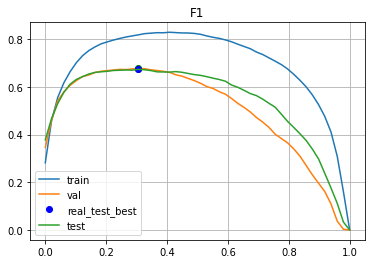

In [152]:
plt.title('F1')
plt.plot(np.linspace(0,1,50), res_train, label='train')
plt.plot(np.linspace(0,1,50), res_val, label='val')
plt.plot(np.linspace(0,1,50)[np.argmax(res_val)], np.max(res_val), 'go')
plt.plot(np.linspace(0,1,50)[np.argmax(res_val)], res_test[np.argmax(res_val)], 'go')
plt.plot(np.linspace(0,1,50)[np.argmax(res_test)], np.max(res_test), 'bo', label='real_test_best')
plt.plot(np.linspace(0,1,50), res_test, label='test')
plt.grid()
plt.legend()

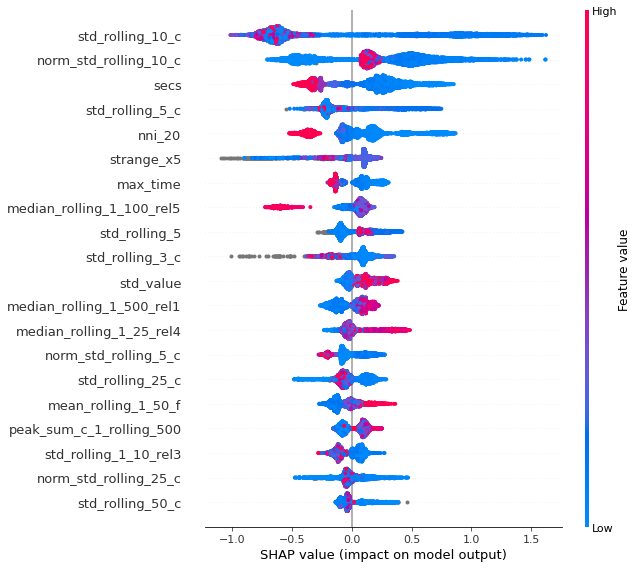

In [153]:
shap_values = cb.get_feature_importance(val_pool, type='ShapValues')[:,:-1]
shap.summary_plot(shap_values, df_val[new_cols])

In [154]:
cb_imps = pd.DataFrame({'cols':new_cols, 
                        'imps': np.mean(np.abs(shap_values),axis=0)}).sort_values(by=['imps'], ascending=False)

In [155]:
cb_imps.head()

,cols,imps
0,std_rolling_10_c,0.685248
1,norm_std_rolling_10_c,0.435048
2,secs,0.303356
3,std_rolling_5_c,0.229264
4,nni_20,0.218230


In [156]:
new_cols2 = list(cb_imps[cb_imps.imps>0.03]['cols'])
len(new_cols2)

44

In [157]:
train_pool = Pool(df_train[new_cols2], df_train['y'])
val_pool = Pool(df_val[new_cols2], df_val['y'])
test_pool = Pool(df_test[new_cols2], df_test['y'])

In [158]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective, n_trials=50)

[I 2021-06-19 06:12:05,168] A new study created in memory with name: no-name-1f0e47b1-a16f-474d-8fa0-788523dc9e4e


TRAIN GINI = 0.9272395883297202
Validate GINI = 0.7962008656967887


[I 2021-06-19 06:12:11,104] Trial 0 finished with value: 0.6674634000597549 and parameters: {'max_depth': 7, 'n_estimators': 362, 'reg_lambda': 46.81780660454441, 'learning_rate': 0.015909205428572236, 'border_count': 63, 'random_strength': 0.6194140390686057, 'bagging_temperature': 0.4594956466048983}. Best is trial 0 with value: 0.6674634000597549.


f1 train =  0.7951
f1 val =  0.6675
f1 test =  0.6708
TRAIN GINI = 0.9033397816118582
Validate GINI = 0.7803006994074453


[I 2021-06-19 06:12:30,018] Trial 1 finished with value: 0.6498306128734216 and parameters: {'max_depth': 3, 'n_estimators': 771, 'reg_lambda': 14.232001647293036, 'learning_rate': 0.01449970498535255, 'border_count': 97, 'random_strength': 4.939550487964802e-05, 'bagging_temperature': 0.18810095694396067}. Best is trial 0 with value: 0.6674634000597549.


f1 train =  0.762
f1 val =  0.6498
f1 test =  0.6543
TRAIN GINI = 0.9454044146695146
Validate GINI = 0.8077051688986456


[I 2021-06-19 06:12:46,127] Trial 2 finished with value: 0.6764447051921384 and parameters: {'max_depth': 5, 'n_estimators': 901, 'reg_lambda': 36.981564938686354, 'learning_rate': 0.04390417581135007, 'border_count': 153, 'random_strength': 2.0078651102214093e-09, 'bagging_temperature': 0.4752906118151079}. Best is trial 2 with value: 0.6764447051921384.


f1 train =  0.8222
f1 val =  0.6764
f1 test =  0.6783
TRAIN GINI = 0.8691323183050668
Validate GINI = 0.761125191165962


[I 2021-06-19 06:12:49,243] Trial 3 finished with value: 0.6340462935833577 and parameters: {'max_depth': 3, 'n_estimators': 182, 'reg_lambda': 15.503014554762217, 'learning_rate': 0.03249783866119595, 'border_count': 9, 'random_strength': 9.79313921608687e-09, 'bagging_temperature': 0.4456299985579515}. Best is trial 2 with value: 0.6764447051921384.


f1 train =  0.7186
f1 val =  0.634
f1 test =  0.6543
TRAIN GINI = 0.9352151625122604
Validate GINI = 0.7940540349732346


[I 2021-06-19 06:13:04,228] Trial 4 finished with value: 0.6676593210244194 and parameters: {'max_depth': 4, 'n_estimators': 518, 'reg_lambda': 84.84792248860803, 'learning_rate': 0.050002178623864836, 'border_count': 194, 'random_strength': 0.5842953936801822, 'bagging_temperature': 0.011005647279402342}. Best is trial 2 with value: 0.6764447051921384.


f1 train =  0.8041
f1 val =  0.6677
f1 test =  0.6623
TRAIN GINI = 0.8994072791534529
Validate GINI = 0.7710357689045604


[I 2021-06-19 06:13:09,292] Trial 5 finished with value: 0.6512866015971607 and parameters: {'max_depth': 2, 'n_estimators': 491, 'reg_lambda': 35.91515067342391, 'learning_rate': 0.03975016158359716, 'border_count': 222, 'random_strength': 0.0014124945536712083, 'bagging_temperature': 0.445612826144383}. Best is trial 2 with value: 0.6764447051921384.


f1 train =  0.7571
f1 val =  0.6513
f1 test =  0.6585
TRAIN GINI = 0.9483735700055547
Validate GINI = 0.8003282855024887


[I 2021-06-19 06:13:27,925] Trial 6 finished with value: 0.6752058554437329 and parameters: {'max_depth': 4, 'n_estimators': 880, 'reg_lambda': 10.410412355324283, 'learning_rate': 0.03940241212664786, 'border_count': 200, 'random_strength': 1.9937244302228e-09, 'bagging_temperature': 0.34769403224933404}. Best is trial 2 with value: 0.6764447051921384.


f1 train =  0.8266
f1 val =  0.6752
f1 test =  0.6711
TRAIN GINI = 0.9411966497059683
Validate GINI = 0.8054306159383993


[I 2021-06-19 06:13:51,376] Trial 7 finished with value: 0.6793303283966516 and parameters: {'max_depth': 6, 'n_estimators': 927, 'reg_lambda': 97.37389057186175, 'learning_rate': 0.0396831958887603, 'border_count': 86, 'random_strength': 1.8389692778014723e-08, 'bagging_temperature': 0.016251915826935304}. Best is trial 7 with value: 0.6793303283966516.


f1 train =  0.821
f1 val =  0.6793
f1 test =  0.6725
TRAIN GINI = 0.9206961758733048
Validate GINI = 0.7789482270579375


[I 2021-06-19 06:14:11,145] Trial 8 finished with value: 0.6588902900378311 and parameters: {'max_depth': 3, 'n_estimators': 794, 'reg_lambda': 72.59950697978712, 'learning_rate': 0.030941038743315916, 'border_count': 238, 'random_strength': 7.974608854989741e-06, 'bagging_temperature': 0.1634177252062965}. Best is trial 7 with value: 0.6793303283966516.


f1 train =  0.7861
f1 val =  0.6589
f1 test =  0.6539
TRAIN GINI = 0.9753463895626968
Validate GINI = 0.8124039399984542


[I 2021-06-19 06:14:15,667] Trial 9 finished with value: 0.683617637592533 and parameters: {'max_depth': 7, 'n_estimators': 425, 'reg_lambda': 12.882883422525415, 'learning_rate': 0.08412036439028263, 'border_count': 174, 'random_strength': 1.9233579223620354e-08, 'bagging_temperature': 0.5452405750060005}. Best is trial 9 with value: 0.683617637592533.


f1 train =  0.8807
f1 val =  0.6836
f1 test =  0.669
TRAIN GINI = 0.9637830430283985
Validate GINI = 0.8013801156870097


[I 2021-06-19 06:14:18,899] Trial 10 finished with value: 0.6820135052179251 and parameters: {'max_depth': 7, 'n_estimators': 101, 'reg_lambda': 1.7038113968032018, 'learning_rate': 0.09954974558158011, 'border_count': 153, 'random_strength': 7.667954080771583e-07, 'bagging_temperature': 0.8608766148698521}. Best is trial 9 with value: 0.683617637592533.


f1 train =  0.8543
f1 val =  0.682
f1 test =  0.6729
TRAIN GINI = 0.9664752507541119
Validate GINI = 0.7951727672817372


[I 2021-06-19 06:14:22,336] Trial 11 finished with value: 0.6664758087603779 and parameters: {'max_depth': 7, 'n_estimators': 118, 'reg_lambda': 4.10619802757452, 'learning_rate': 0.0894210665830471, 'border_count': 157, 'random_strength': 1.056392096744249e-06, 'bagging_temperature': 0.8734870684845217}. Best is trial 9 with value: 0.683617637592533.


f1 train =  0.8595
f1 val =  0.6665
f1 test =  0.6651
TRAIN GINI = 0.9702744464900896
Validate GINI = 0.8001279368959131


[I 2021-06-19 06:14:26,485] Trial 12 finished with value: 0.6698679471788715 and parameters: {'max_depth': 6, 'n_estimators': 274, 'reg_lambda': 0.7694409324046951, 'learning_rate': 0.09320795624576012, 'border_count': 140, 'random_strength': 3.2623033089916815e-07, 'bagging_temperature': 0.8291443889879768}. Best is trial 9 with value: 0.683617637592533.


f1 train =  0.8675
f1 val =  0.6699
f1 test =  0.668
TRAIN GINI = 0.9808895430688842
Validate GINI = 0.8170690811535883


[I 2021-06-19 06:14:32,457] Trial 13 finished with value: 0.6867268472082916 and parameters: {'max_depth': 7, 'n_estimators': 352, 'reg_lambda': 22.977409244995393, 'learning_rate': 0.06895001564844515, 'border_count': 183, 'random_strength': 0.0012577249911827776, 'bagging_temperature': 0.7063922656602171}. Best is trial 13 with value: 0.6867268472082916.


f1 train =  0.8948
f1 val =  0.6867
f1 test =  0.6768
TRAIN GINI = 0.969712034037107
Validate GINI = 0.8093132049766592


[I 2021-06-19 06:14:37,874] Trial 14 finished with value: 0.6778398510242086 and parameters: {'max_depth': 6, 'n_estimators': 379, 'reg_lambda': 27.15075794892077, 'learning_rate': 0.06556756636080385, 'border_count': 193, 'random_strength': 0.005568084215990803, 'bagging_temperature': 0.6565490190021356}. Best is trial 13 with value: 0.6867268472082916.


f1 train =  0.8689
f1 val =  0.6778
f1 test =  0.668
TRAIN GINI = 0.9536997748166429
Validate GINI = 0.807806058732671


[I 2021-06-19 06:14:54,843] Trial 15 finished with value: 0.6820305200872002 and parameters: {'max_depth': 5, 'n_estimators': 609, 'reg_lambda': 65.13830498303501, 'learning_rate': 0.06453336352907382, 'border_count': 251, 'random_strength': 0.00737106141796349, 'bagging_temperature': 0.68531150922113}. Best is trial 13 with value: 0.6867268472082916.


f1 train =  0.8383
f1 val =  0.682
f1 test =  0.6705
TRAIN GINI = 0.8752719703885063
Validate GINI = 0.7663410524789325


[I 2021-06-19 06:15:09,211] Trial 16 finished with value: 0.6454906409529213 and parameters: {'max_depth': 1, 'n_estimators': 619, 'reg_lambda': 23.560792562361428, 'learning_rate': 0.0693386317661207, 'border_count': 114, 'random_strength': 0.0003376270953819626, 'bagging_temperature': 0.6580424448784608}. Best is trial 13 with value: 0.6867268472082916.


f1 train =  0.7326
f1 val =  0.6455
f1 test =  0.6489
TRAIN GINI = 0.9482656659572084
Validate GINI = 0.8035163327046204


[I 2021-06-19 06:15:15,794] Trial 17 finished with value: 0.6745195288282703 and parameters: {'max_depth': 7, 'n_estimators': 399, 'reg_lambda': 52.41947117110066, 'learning_rate': 0.02399097143070749, 'border_count': 170, 'random_strength': 0.05581068143300933, 'bagging_temperature': 0.5956220208284626}. Best is trial 13 with value: 0.6867268472082916.


f1 train =  0.8284
f1 val =  0.6745
f1 test =  0.6667
TRAIN GINI = 0.9442974438542009
Validate GINI = 0.8003674011828199


[I 2021-06-19 06:15:20,013] Trial 18 finished with value: 0.6702910137511991 and parameters: {'max_depth': 5, 'n_estimators': 283, 'reg_lambda': 26.019220251031154, 'learning_rate': 0.07478890320170971, 'border_count': 212, 'random_strength': 4.559703251270922e-05, 'bagging_temperature': 0.7558984706780913}. Best is trial 13 with value: 0.6867268472082916.


f1 train =  0.8232
f1 val =  0.6703
f1 test =  0.6674
TRAIN GINI = 0.9744661628328259
Validate GINI = 0.8114173423661935


[I 2021-06-19 06:15:26,443] Trial 19 finished with value: 0.6886702634084417 and parameters: {'max_depth': 6, 'n_estimators': 463, 'reg_lambda': 37.26097173505596, 'learning_rate': 0.05783942956835785, 'border_count': 127, 'random_strength': 0.08626564137724772, 'bagging_temperature': 0.9419463437411744}. Best is trial 19 with value: 0.6886702634084417.


f1 train =  0.8775
f1 val =  0.6887
f1 test =  0.6758
TRAIN GINI = 0.9484979124269293
Validate GINI = 0.8004481369010648


[I 2021-06-19 06:15:31,004] Trial 20 finished with value: 0.6730641958967571 and parameters: {'max_depth': 6, 'n_estimators': 272, 'reg_lambda': 46.54750214222687, 'learning_rate': 0.056765332282539126, 'border_count': 58, 'random_strength': 4.339930440101269, 'bagging_temperature': 0.9742602296745102}. Best is trial 19 with value: 0.6886702634084417.


f1 train =  0.8271
f1 val =  0.6731
f1 test =  0.6629
TRAIN GINI = 0.978934574593276
Validate GINI = 0.8122595220445477


[I 2021-06-19 06:15:36,025] Trial 21 finished with value: 0.6807875894988067 and parameters: {'max_depth': 7, 'n_estimators': 448, 'reg_lambda': 34.50038309446887, 'learning_rate': 0.0914563176271756, 'border_count': 125, 'random_strength': 0.05577274655706154, 'bagging_temperature': 0.6012280292527437}. Best is trial 19 with value: 0.6886702634084417.


f1 train =  0.8893
f1 val =  0.6808
f1 test =  0.6779
TRAIN GINI = 0.9705375865548689
Validate GINI = 0.814453816307041


[I 2021-06-19 06:15:55,019] Trial 22 finished with value: 0.6969696969696969 and parameters: {'max_depth': 6, 'n_estimators': 592, 'reg_lambda': 17.715453631969382, 'learning_rate': 0.08009250292080419, 'border_count': 175, 'random_strength': 0.03724661700600088, 'bagging_temperature': 0.9857527942116742}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.8698
f1 val =  0.697
f1 test =  0.6686
TRAIN GINI = 0.9658049858376365
Validate GINI = 0.8201890336805089


[I 2021-06-19 06:16:17,539] Trial 23 finished with value: 0.6910112359550561 and parameters: {'max_depth': 6, 'n_estimators': 607, 'reg_lambda': 22.324594386461612, 'learning_rate': 0.05369818825409957, 'border_count': 113, 'random_strength': 0.058254660889548726, 'bagging_temperature': 0.945480310567713}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.8595
f1 val =  0.691
f1 test =  0.6733
TRAIN GINI = 0.9284635020058853
Validate GINI = 0.7997156719358349


[I 2021-06-19 06:16:28,564] Trial 24 finished with value: 0.6702997275204359 and parameters: {'max_depth': 5, 'n_estimators': 651, 'reg_lambda': 56.17838199831294, 'learning_rate': 0.054441337829180404, 'border_count': 107, 'random_strength': 2.2721020242160854, 'bagging_temperature': 0.9973800040175665}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.793
f1 val =  0.6703
f1 test =  0.6615
TRAIN GINI = 0.9459011939950346
Validate GINI = 0.8114163883252095


[I 2021-06-19 06:16:44,491] Trial 25 finished with value: 0.6827889447236181 and parameters: {'max_depth': 6, 'n_estimators': 689, 'reg_lambda': 42.61667528566621, 'learning_rate': 0.049766447018776465, 'border_count': 67, 'random_strength': 0.05337054600269639, 'bagging_temperature': 0.940210280855555}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.8252
f1 val =  0.6828
f1 test =  0.6726
TRAIN GINI = 0.9434727224257309
Validate GINI = 0.8008403670004853


[I 2021-06-19 06:17:04,007] Trial 26 finished with value: 0.6738211382113821 and parameters: {'max_depth': 5, 'n_estimators': 564, 'reg_lambda': 28.762996782575488, 'learning_rate': 0.02971762416080288, 'border_count': 127, 'random_strength': 0.01453285397311534, 'bagging_temperature': 0.9171311510266669}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.8191
f1 val =  0.6738
f1 test =  0.6627
TRAIN GINI = 0.971991396724136
Validate GINI = 0.8259807779822606


[I 2021-06-19 06:17:28,591] Trial 27 finished with value: 0.6924829157175398 and parameters: {'max_depth': 6, 'n_estimators': 728, 'reg_lambda': 20.166211971847417, 'learning_rate': 0.056868669792305475, 'border_count': 26, 'random_strength': 7.8668278897126465, 'bagging_temperature': 0.7791385081417496}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.8718
f1 val =  0.6925
f1 test =  0.6869
TRAIN GINI = 0.9370194917549666
Validate GINI = 0.8002564939184658


[I 2021-06-19 06:17:39,623] Trial 28 finished with value: 0.6679462571976967 and parameters: {'max_depth': 4, 'n_estimators': 718, 'reg_lambda': 18.431478076919277, 'learning_rate': 0.07679994623111795, 'border_count': 21, 'random_strength': 7.387983283252945, 'bagging_temperature': 0.7860464739096021}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.8111
f1 val =  0.6679
f1 test =  0.6751
TRAIN GINI = 0.9506909908505035
Validate GINI = 0.8110886752473112


[I 2021-06-19 06:18:24,448] Trial 29 finished with value: 0.6808773555761508 and parameters: {'max_depth': 6, 'n_estimators': 998, 'reg_lambda': 4.629035316499305, 'learning_rate': 0.011116315860830861, 'border_count': 35, 'random_strength': 0.5284360004127654, 'bagging_temperature': 0.801018690923662}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.8291
f1 val =  0.6809
f1 test =  0.6689
TRAIN GINI = 0.9517880860323686
Validate GINI = 0.8119592376449307


[I 2021-06-19 06:18:49,558] Trial 30 finished with value: 0.6802804023163669 and parameters: {'max_depth': 5, 'n_estimators': 756, 'reg_lambda': 8.005222450723267, 'learning_rate': 0.02487701501949504, 'border_count': 77, 'random_strength': 1.116535737501446, 'bagging_temperature': 0.9929541144143672}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.8333
f1 val =  0.6803
f1 test =  0.6707
TRAIN GINI = 0.9478559503995823
Validate GINI = 0.809991528116065


[I 2021-06-19 06:19:03,905] Trial 31 finished with value: 0.6817010309278351 and parameters: {'max_depth': 6, 'n_estimators': 548, 'reg_lambda': 31.507515466987567, 'learning_rate': 0.05737669171411278, 'border_count': 52, 'random_strength': 0.15922204855285202, 'bagging_temperature': 0.9247144563189194}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.8308
f1 val =  0.6817
f1 test =  0.6727
TRAIN GINI = 0.9597352828143269
Validate GINI = 0.8105458259275904


[I 2021-06-19 06:19:26,136] Trial 32 finished with value: 0.6860943934114665 and parameters: {'max_depth': 6, 'n_estimators': 590, 'reg_lambda': 19.872776437190616, 'learning_rate': 0.04496148549764386, 'border_count': 140, 'random_strength': 0.19864186603856734, 'bagging_temperature': 0.8909067382021493}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.8487
f1 val =  0.6861
f1 test =  0.6697
TRAIN GINI = 0.9526996534260215
Validate GINI = 0.8042889866462886


[I 2021-06-19 06:19:42,673] Trial 33 finished with value: 0.6783589101158785 and parameters: {'max_depth': 5, 'n_estimators': 823, 'reg_lambda': 38.22267441237957, 'learning_rate': 0.060777990109982395, 'border_count': 100, 'random_strength': 8.444745964221225, 'bagging_temperature': 0.9997859848967935}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.8349
f1 val =  0.6784
f1 test =  0.6723
TRAIN GINI = 0.9591672991972635
Validate GINI = 0.8102667689398604


[I 2021-06-19 06:19:48,461] Trial 34 finished with value: 0.6780963641738101 and parameters: {'max_depth': 6, 'n_estimators': 478, 'reg_lambda': 41.88820208730439, 'learning_rate': 0.04517312835470571, 'border_count': 89, 'random_strength': 0.021025873450939217, 'bagging_temperature': 0.9506617863703104}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.8482
f1 val =  0.6781
f1 test =  0.6658
TRAIN GINI = 0.9725155102898859
Validate GINI = 0.8196519086066898


[I 2021-06-19 06:20:10,863] Trial 35 finished with value: 0.6924528301886792 and parameters: {'max_depth': 7, 'n_estimators': 677, 'reg_lambda': 15.968426988202898, 'learning_rate': 0.07920920126346206, 'border_count': 144, 'random_strength': 0.0023269718572436634, 'bagging_temperature': 0.7370411926331271}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.872
f1 val =  0.6925
f1 test =  0.6822
TRAIN GINI = 0.6825892943399077
Validate GINI = 0.45044460694942545


[I 2021-06-19 06:20:17,327] Trial 36 finished with value: 0.4516982796647552 and parameters: {'max_depth': 7, 'n_estimators': 678, 'reg_lambda': 15.997079612004491, 'learning_rate': 0.08244939282730708, 'border_count': 1, 'random_strength': 0.0015626439447455553, 'bagging_temperature': 0.7411305441872207}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.5125
f1 val =  0.4517
f1 test =  0.4566
TRAIN GINI = 0.9734772926717221
Validate GINI = 0.8149134255509347


[I 2021-06-19 06:20:39,682] Trial 37 finished with value: 0.6908182386008745 and parameters: {'max_depth': 7, 'n_estimators': 736, 'reg_lambda': 9.478512053056935, 'learning_rate': 0.07584240295212269, 'border_count': 157, 'random_strength': 0.0004871887297977065, 'bagging_temperature': 0.8187550179274973}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.8763
f1 val =  0.6908
f1 test =  0.6703
TRAIN GINI = 0.949352948553779
Validate GINI = 0.8045296434844249


[I 2021-06-19 06:21:02,413] Trial 38 finished with value: 0.6807838179519595 and parameters: {'max_depth': 4, 'n_estimators': 814, 'reg_lambda': 19.288404450296948, 'learning_rate': 0.0354891050771218, 'border_count': 174, 'random_strength': 4.8717752284151634e-05, 'bagging_temperature': 0.8441877248508011}. Best is trial 22 with value: 0.6969696969696969.


f1 train =  0.83
f1 val =  0.6808
f1 test =  0.6714
TRAIN GINI = 0.9674367924066363
Validate GINI = 0.8188965466578517


[I 2021-06-19 06:21:14,939] Trial 39 finished with value: 0.7022332506203474 and parameters: {'max_depth': 5, 'n_estimators': 528, 'reg_lambda': 13.399916783715044, 'learning_rate': 0.09691477471679066, 'border_count': 40, 'random_strength': 0.004586214130560057, 'bagging_temperature': 0.762971105842509}. Best is trial 39 with value: 0.7022332506203474.


f1 train =  0.8631
f1 val =  0.7022
f1 test =  0.6738
TRAIN GINI = 0.9590573260231636
Validate GINI = 0.8074717866230097


[I 2021-06-19 06:21:27,090] Trial 40 finished with value: 0.6805555555555555 and parameters: {'max_depth': 5, 'n_estimators': 530, 'reg_lambda': 12.511734268873205, 'learning_rate': 0.08209034262748537, 'border_count': 21, 'random_strength': 0.0001562089491199462, 'bagging_temperature': 0.39851149855676926}. Best is trial 39 with value: 0.7022332506203474.


f1 train =  0.8454
f1 val =  0.6806
f1 test =  0.6773
TRAIN GINI = 0.9571813970050442
Validate GINI = 0.8082515958720553


[I 2021-06-19 06:21:37,235] Trial 41 finished with value: 0.683371298405467 and parameters: {'max_depth': 6, 'n_estimators': 637, 'reg_lambda': 7.696607697153727, 'learning_rate': 0.09955658096525852, 'border_count': 43, 'random_strength': 0.007394260684841254, 'bagging_temperature': 0.7407078718302634}. Best is trial 39 with value: 0.7022332506203474.


f1 train =  0.842
f1 val =  0.6834
f1 test =  0.6715
TRAIN GINI = 0.9615411538709608
Validate GINI = 0.8162741265039264


[I 2021-06-19 06:21:56,198] Trial 42 finished with value: 0.6860537836147592 and parameters: {'max_depth': 5, 'n_estimators': 681, 'reg_lambda': 15.724018962674538, 'learning_rate': 0.0498393718565184, 'border_count': 14, 'random_strength': 0.0016451111742348012, 'bagging_temperature': 0.6004773200319979}. Best is trial 39 with value: 0.7022332506203474.


f1 train =  0.8488
f1 val =  0.6861
f1 test =  0.6747
TRAIN GINI = 0.9704853941473353
Validate GINI = 0.8178578345368563


[I 2021-06-19 06:22:15,219] Trial 43 finished with value: 0.6969410280668559 and parameters: {'max_depth': 6, 'n_estimators': 574, 'reg_lambda': 30.865878836076263, 'learning_rate': 0.07357084162913195, 'border_count': 34, 'random_strength': 0.31678587040974676, 'bagging_temperature': 0.5192031601282283}. Best is trial 39 with value: 0.7022332506203474.


f1 train =  0.8733
f1 val =  0.6969
f1 test =  0.6759
TRAIN GINI = 0.965005202819575
Validate GINI = 0.8209670541027103


[I 2021-06-19 06:22:32,550] Trial 44 finished with value: 0.692898272552783 and parameters: {'max_depth': 7, 'n_estimators': 520, 'reg_lambda': 31.140246098669074, 'learning_rate': 0.09728272955501119, 'border_count': 36, 'random_strength': 0.4563878927816292, 'bagging_temperature': 0.28224779654605314}. Best is trial 39 with value: 0.7022332506203474.


f1 train =  0.8588
f1 val =  0.6929
f1 test =  0.6852
TRAIN GINI = 0.9607553847378572
Validate GINI = 0.8120148105322309


[I 2021-06-19 06:22:45,642] Trial 45 finished with value: 0.6857494613727301 and parameters: {'max_depth': 4, 'n_estimators': 502, 'reg_lambda': 32.15905000586085, 'learning_rate': 0.09623458677592239, 'border_count': 34, 'random_strength': 0.38300566169009975, 'bagging_temperature': 0.24880172343567675}. Best is trial 39 with value: 0.7022332506203474.


f1 train =  0.8521
f1 val =  0.6857
f1 test =  0.6691
TRAIN GINI = 0.9328876596944522
Validate GINI = 0.7901049015763619


[I 2021-06-19 06:22:55,576] Trial 46 finished with value: 0.665015479876161 and parameters: {'max_depth': 6, 'n_estimators': 573, 'reg_lambda': 29.267626676363832, 'learning_rate': 0.08846782195252374, 'border_count': 7, 'random_strength': 1.5871211739348339, 'bagging_temperature': 0.07345546217470023}. Best is trial 39 with value: 0.7022332506203474.


f1 train =  0.7989
f1 val =  0.665
f1 test =  0.6653
TRAIN GINI = 0.9539383203700313
Validate GINI = 0.8140321301922488


[I 2021-06-19 06:23:08,149] Trial 47 finished with value: 0.685382381413359 and parameters: {'max_depth': 5, 'n_estimators': 503, 'reg_lambda': 25.654068843420834, 'learning_rate': 0.07066237026673024, 'border_count': 32, 'random_strength': 0.28594782161381926, 'bagging_temperature': 0.27950672081323846}. Best is trial 39 with value: 0.7022332506203474.


f1 train =  0.838
f1 val =  0.6854
f1 test =  0.6847
TRAIN GINI = 0.978531175314268
Validate GINI = 0.8152184801554703


[I 2021-06-19 06:23:41,644] Trial 48 finished with value: 0.7014742014742015 and parameters: {'max_depth': 7, 'n_estimators': 860, 'reg_lambda': 41.93567655272126, 'learning_rate': 0.06258125221114776, 'border_count': 48, 'random_strength': 0.021237879262902642, 'bagging_temperature': 0.4973660629187455}. Best is trial 39 with value: 0.7022332506203474.


f1 train =  0.8857
f1 val =  0.7015
f1 test =  0.6801
TRAIN GINI = 0.9804966327099054
Validate GINI = 0.8226096741663829


[I 2021-06-19 06:24:10,055] Trial 49 finished with value: 0.703883495145631 and parameters: {'max_depth': 7, 'n_estimators': 989, 'reg_lambda': 58.01031628309935, 'learning_rate': 0.0971462305296632, 'border_count': 49, 'random_strength': 0.019711246532900503, 'bagging_temperature': 0.5018454328859184}. Best is trial 49 with value: 0.703883495145631.


f1 train =  0.896
f1 val =  0.7039
f1 test =  0.674


In [159]:
best_params = {'max_depth': 7, 'n_estimators': 989, 'reg_lambda': 58.01031628309935,
               'learning_rate': 0.0971462305296632, 'border_count': 49, 
               'random_strength': 0.019711246532900503, 'bagging_temperature': 0.5018454328859184,
                       'task_type': 'GPU',
        "loss_function":'Logloss',
        'random_state':123}

In [160]:
cb = CatBoostClassifier(**best_params)
cb.fit(train_pool, eval_set=val_pool, verbose=100, early_stopping_rounds=50)

0:	learn: 0.5831625	test: 0.6088445	best: 0.6088445 (0)	total: 70.3ms	remaining: 1m 9s
100:	learn: 0.1590972	test: 0.3104735	best: 0.3099018 (97)	total: 6.69s	remaining: 58.8s
200:	learn: 0.1300228	test: 0.2996371	best: 0.2990712 (185)	total: 13.2s	remaining: 51.7s
300:	learn: 0.1072543	test: 0.2970604	best: 0.2960170 (292)	total: 19.7s	remaining: 45.1s
bestTest = 0.2957897323
bestIteration = 336
Shrink model to first 337 iterations.


In [161]:
res_val = []
res_train = []
res_test = []
for i in np.linspace(0,1,50):
    res_val.append(f1_score(df_val['y'], cb.predict_proba(val_pool)[:,1]>i))
    res_train.append(f1_score(df_train['y'], cb.predict_proba(train_pool)[:,1]>i))
    res_test.append(f1_score(df_test['y'], cb.predict_proba(test_pool)[:,1]>i))
print(np.max(res_val), res_test[np.argmax(res_val)], np.linspace(0,1,50)[np.argmax(res_val)])

0.703883495145631 0.673996701484332 0.2040816326530612


0.2040816326530612


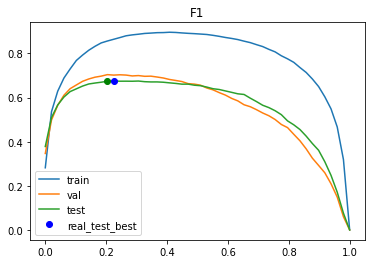

In [162]:
plt.title('F1')
plt.plot(np.linspace(0,1,50), res_train, label='train')
plt.plot(np.linspace(0,1,50), res_val, label='val')
plt.plot(np.linspace(0,1,50), res_test, label='test')
plt.plot(np.linspace(0,1,50)[np.argmax(res_val)], res_test[np.argmax(res_val)], 'go')
plt.plot(np.linspace(0,1,50)[np.argmax(res_test)], np.max(res_test), 'bo', label='real_test_best')
plt.legend()
print(np.linspace(0,1,50)[np.argmax(res_val)])

In [163]:
len(new_cols2)

44

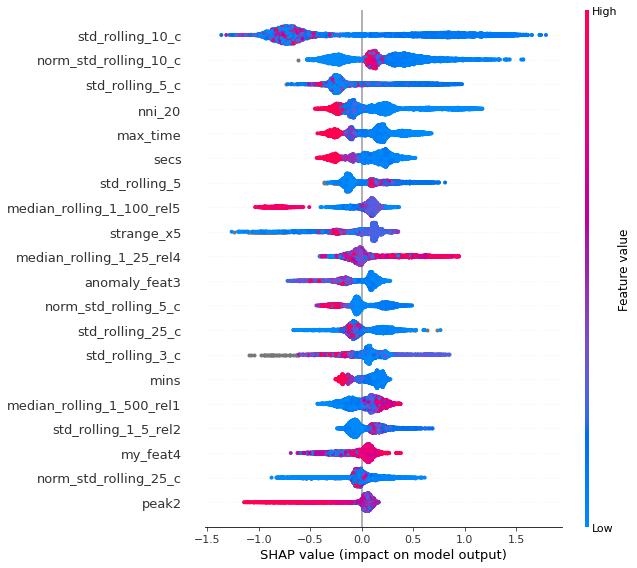

In [164]:
shap_values = cb.get_feature_importance(val_pool, type='ShapValues')[:,:-1]
shap.summary_plot(shap_values, df_val[new_cols2])

In [165]:
cb_imps = pd.DataFrame({'cols':new_cols2, 
                        'imps': np.mean(np.abs(shap_values),axis=0)}).sort_values(by=['imps'], ascending=False)

In [166]:
cb_imps.head()

,cols,imps
0,std_rolling_10_c,0.727997
1,norm_std_rolling_10_c,0.349438
3,std_rolling_5_c,0.274854
4,nni_20,0.250958
6,max_time,0.225250


In [167]:
new_cols3 = list(cb_imps[cb_imps.imps>0.03]['cols'])
len(new_cols3)

44

In [168]:
new_cols3

['std_rolling_10_c',
 'norm_std_rolling_10_c',
 'std_rolling_5_c',
 'nni_20',
 'max_time',
 'secs',
 'std_rolling_5',
 'median_rolling_1_100_rel5',
 'strange_x5',
 'median_rolling_1_25_rel4',
 'anomaly_feat3',
 'norm_std_rolling_5_c',
 'std_rolling_25_c',
 'std_rolling_3_c',
 'mins',
 'median_rolling_1_500_rel1',
 'std_rolling_1_5_rel2',
 'my_feat4',
 'norm_std_rolling_25_c',
 'peak2',
 'peak_mean_c_1_rolling_500',
 'peak_sum_c_1_rolling_500',
 'median_rolling_1_10000_rel4',
 'triangular_index',
 'std_rolling_50_c',
 'std_rolling_1_10',
 'time',
 'std_rolling_2_c',
 'norm_std_rolling_50_c',
 'std_value',
 'median_rolling_1_50_rel5',
 'std_rolling_1_25_rel3',
 'mean_rolling_1_50_f',
 'std_rolling_1_10_rel3',
 'min_rolling_1_10000',
 'min_rolling_1_5_rel3',
 'peak_new2',
 'time_share',
 'norm_mean_rolling_1_25_rel4',
 'median_rolling_1_25_rel5',
 'std_rolling_1_50_rel3',
 'anomaly2_cumsum',
 'max_rolling_1_50_c',
 'std_rolling_1_25']

In [169]:
# train_pool = Pool(df_train[new_cols3], df_train['y'])
# val_pool = Pool(df_val[new_cols3], df_val['y'])
# test_pool = Pool(df_test[new_cols3], df_test['y'])

In [170]:
# study_cb = optuna.create_study(direction='maximize')
# study_cb.optimize(objective, n_trials=50)

In [171]:
# best_params =   {'max_depth': 7, 'n_estimators': 878, 'reg_lambda': 83.25355929594545,
#                  'learning_rate': 0.041665155592259646, 'border_count': 185,
#                  'random_strength': 1.191893915621094e-05, 'bagging_temperature': 0.31466396826184945,
#                        'task_type': 'GPU',
#         "loss_function":'Logloss',
#         'random_state':123}
# cb = CatBoostClassifier(**best_params)

In [172]:
# cb.fit(train_pool, eval_set=val_pool, verbose=100, early_stopping_rounds=50)

In [173]:
# res_val = []
# res_train = []
# res_test = []
# for i in np.linspace(0,1,50):
#     res_val.append(f1_score(df_val['y'], cb.predict_proba(val_pool)[:,1]>i))
#     res_train.append(f1_score(df_train['y'], cb.predict_proba(train_pool)[:,1]>i))
#     res_test.append(f1_score(df_test['y'], cb.predict_proba(test_pool)[:,1]>i))
# print(np.max(res_val), res_test[np.argmax(res_val)], np.linspace(0,1,50)[np.argmax(res_val)])

In [174]:
# plt.title('F1')
# plt.plot(np.linspace(0,1,50), res_train, label='train')
# plt.plot(np.linspace(0,1,50), res_val, label='val')
# plt.plot(np.linspace(0,1,50), res_test, label='test')
# plt.plot(np.linspace(0,1,50)[np.argmax(res_val)], res_test[np.argmax(res_val)], 'go')
# plt.plot(np.linspace(0,1,50)[np.argmax(res_test)], np.max(res_test), 'bo', label='real_test_best')
# plt.legend()
# print(np.linspace(0,1,50)[np.argmax(res_val)])

In [175]:
# len(new_cols3)

In [176]:
# shap_values2 = cb.get_feature_importance(val_pool, type='ShapValues')[:,:-1]
# shap.summary_plot(shap_values2, df_val[new_cols3])

In [177]:
# cb_imps2 = pd.DataFrame({'cols':new_cols3, 
#                         'imps': np.mean(np.abs(shap_values2),axis=0)}).sort_values(by=['imps'], ascending=False)

In [ ]:
# cb_imps2.tail(5)

In [178]:
train_val_pool = Pool(pd.concat([df_train[new_cols3], df_val[new_cols3]]),
                      pd.concat([df_train['y'], df_val['y']]))

In [179]:
cb.fit(train_val_pool, verbose=0)

In [182]:
test_pool = Pool(df_test[new_cols3], df_test['y'])

f1_score(df_test['y'], cb.predict_proba(test_pool)[:,1]>0.204)

0.6985482493595218

In [183]:
f1_score(df_test['y'], cb.predict_proba(test_pool)[:,1]>0.204, average='micro')

0.8476697353279632

In [184]:
cb.save_model('1906_best_model')

In [185]:
all_pool = Pool(pd.concat([df_train[new_cols2], df_val[new_cols2], df_test[new_cols2]]),
                pd.concat([df_train['y'], df_val['y'], df_test['y']]))

In [186]:
cb.fit(all_pool, verbose=0)

In [187]:
cb.save_model('1906_all_data_studied')

## Scoring

In [188]:
df = pd.read_csv('train.csv')
df.sort_values(by=['id', 'time'], inplace=True)
df_test_tmp = df[df.id>=225].copy()
df_test2 = df_test_tmp.drop(['y'], axis=1)

In [189]:
new_cols2 = ['std_rolling_10_c', 'norm_std_rolling_10_c',
 'std_rolling_5_c', 'nni_20', 'max_time',
 'secs', 'std_rolling_5', 'median_rolling_1_100_rel5',
 'strange_x5', 'median_rolling_1_25_rel4',
 'anomaly_feat3', 'norm_std_rolling_5_c',
 'std_rolling_25_c', 'std_rolling_3_c',
 'mins', 'median_rolling_1_500_rel1',
 'std_rolling_1_5_rel2', 'my_feat4',
 'norm_std_rolling_25_c',
 'peak2',
 'peak_mean_c_1_rolling_500',
 'peak_sum_c_1_rolling_500',
 'median_rolling_1_10000_rel4',
 'triangular_index',
 'std_rolling_50_c',
 'std_rolling_1_10',
 'time',
 'std_rolling_2_c',
 'norm_std_rolling_50_c',
 'std_value',
 'median_rolling_1_50_rel5',
 'std_rolling_1_25_rel3',
 'mean_rolling_1_50_f',
 'std_rolling_1_10_rel3',
 'min_rolling_1_10000',
 'min_rolling_1_5_rel3',
 'peak_new2',
 'time_share',
 'norm_mean_rolling_1_25_rel4',
 'median_rolling_1_25_rel5',
 'std_rolling_1_50_rel3',
 'anomaly2_cumsum',
 'max_rolling_1_50_c',
 'std_rolling_1_25']

In [190]:
tresh = 0.204

In [191]:
def scoring(test_df, path_to_model, new_cols2, tresh, target_col='pred2_bin'):
  df_test = test_df[['id', 'time', 'x']].copy()
  test_df = anomaly_detected(test_df)
  test_df = first_prepr(test_df)
  test_df = test_df[test_df.x<1100]
  test_df = feature_generate(test_df)
  test_df = new_feats(test_df)
  test_df['change'] = test_df['x'] / test_df['median_rolling_1_100']
  test_df = test_df[test_df['change']>0.8]
  # pred_df = test_df[['id', 'time', 'x', 'anomaly__1', 'less066','mean_rolling_new2_1']].copy()

  # pred_df = test_df[['id', 'time', 'x']]
  # pred_df['pred'] = 0

  # test_df = test_df[(test_df.less066==0) ]

  cb = CatBoostClassifier()
  cb.load_model(path_to_model)
  test_df['pred2'] = cb.predict_proba(Pool(test_df[new_cols2]))[:,1]
  test_df[target_col] = (test_df['pred2'] > tresh).astype(int)

  # df_test = df_test.merge(pred_df[['id', 'time', 'x', 'pred']], 
  #                         on =['id', 'time', 'x'], how='left')
  df_test = df_test.merge(test_df[['id', 'time', 'x', 'pred2', 'pred2_bin']], 
                          on =['id', 'time', 'x'], how='left')
  df_test.loc[(df_test[target_col].isnull()), target_col] = 0#df_test.loc[(df_test[target_col].isnull()), 'pred']
  return df_test

In [192]:
res = scoring(df_test2, '1906_best_model', new_cols2, tresh)

In [193]:
print(res.shape)
res2 = res.merge(df_test_tmp, on =['id', 'time', 'x'])
print(res2.shape)

(8309, 5)
(8309, 6)


In [194]:
f1_score(res2['pred2_bin'], res2['y'], average='micro')

0.8725478396919003

In [195]:
f1_score(res2['pred2_bin'], res2['y'])

0.6985482493595218

In [196]:
res2['mistake'] = 0
res2.loc[res2['pred2_bin']!=res2['y'], 'mistake'] = 1

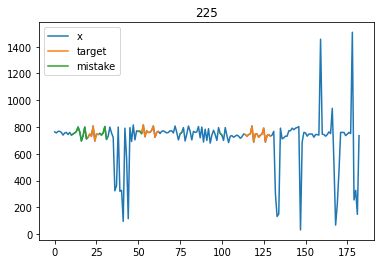

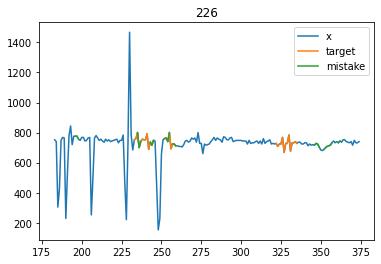

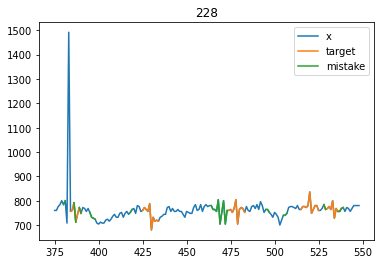

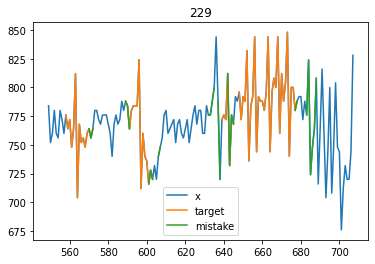

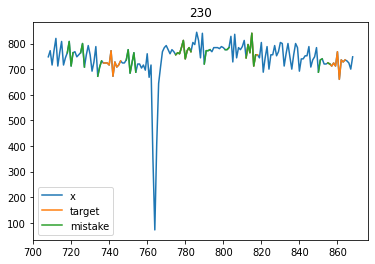

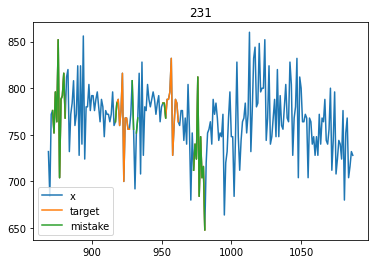

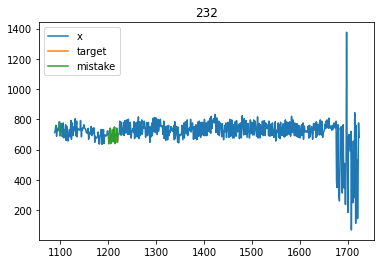

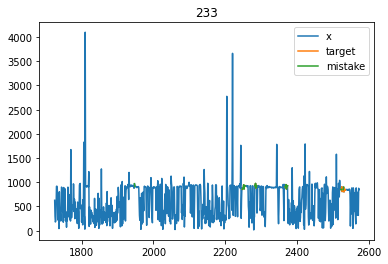

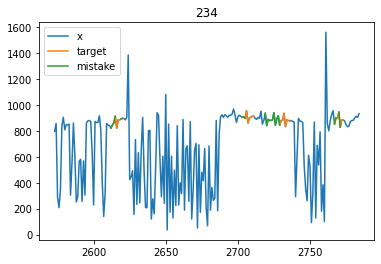

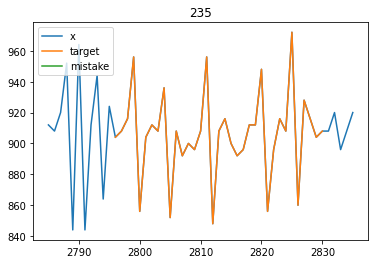

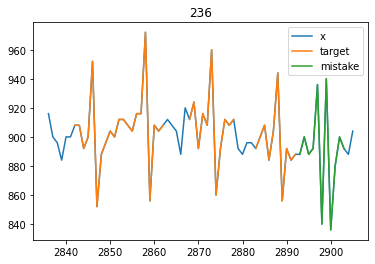

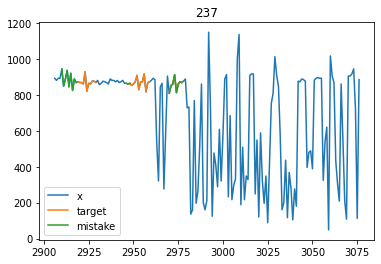

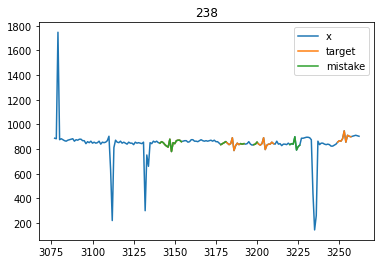

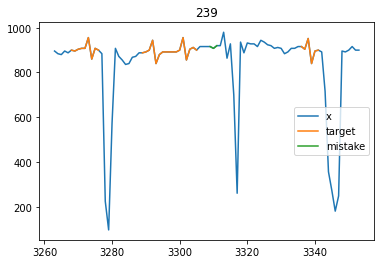

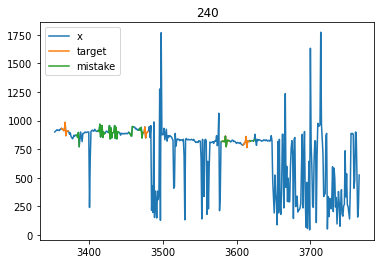

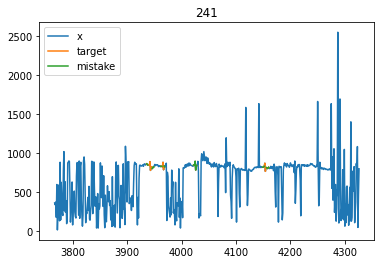

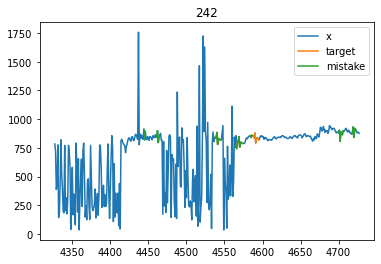

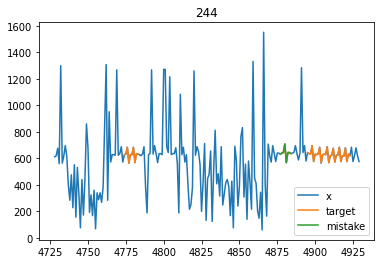

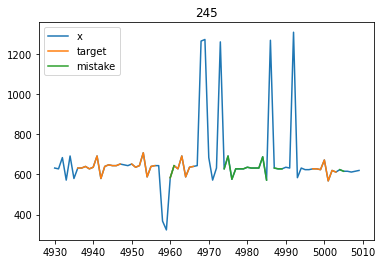

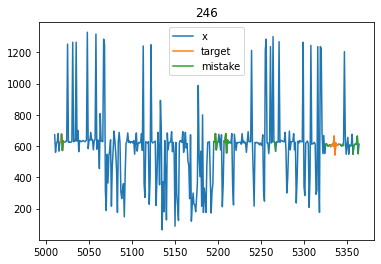

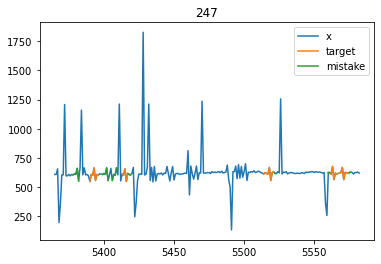

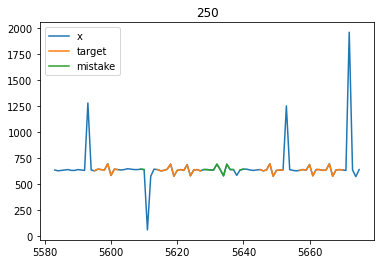

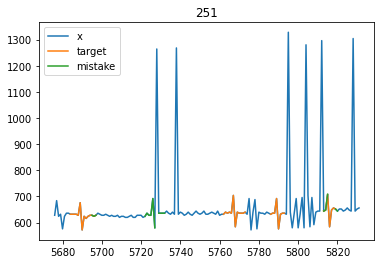

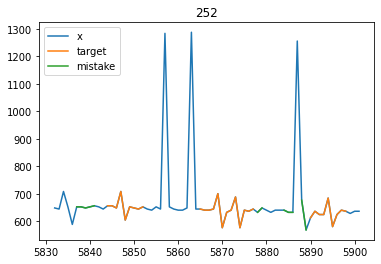

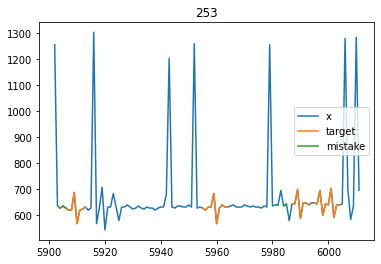

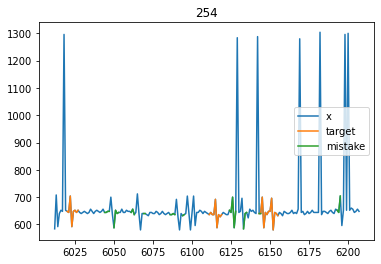

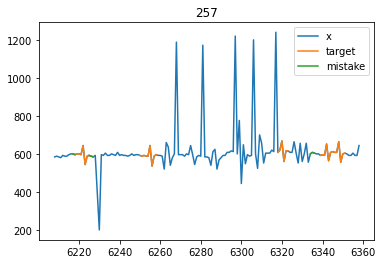

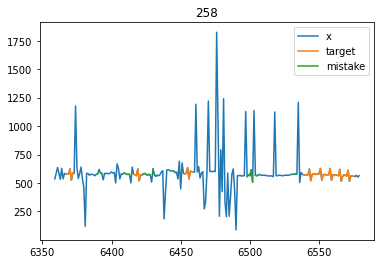

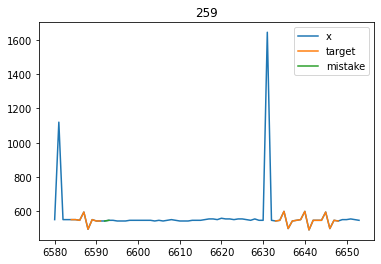

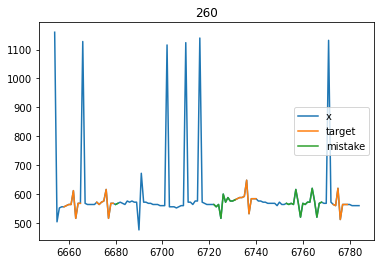

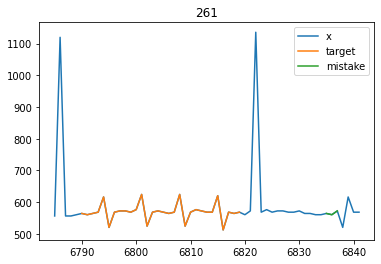

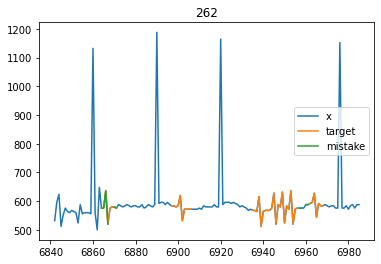

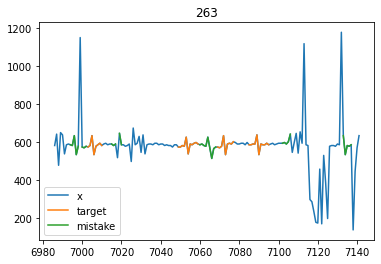

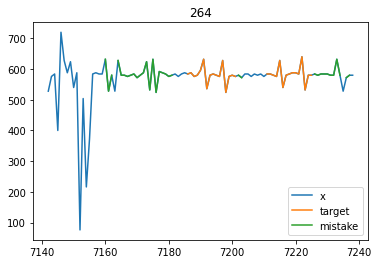

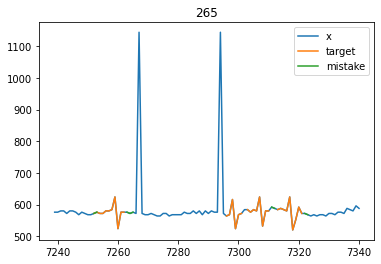

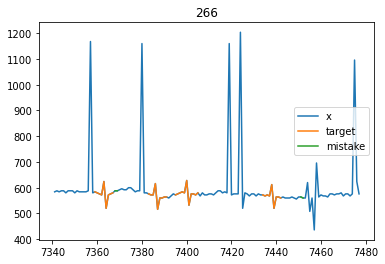

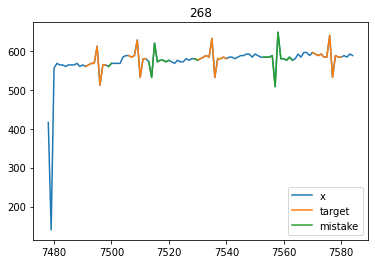

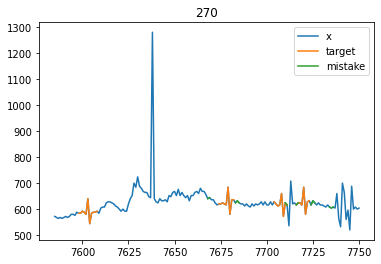

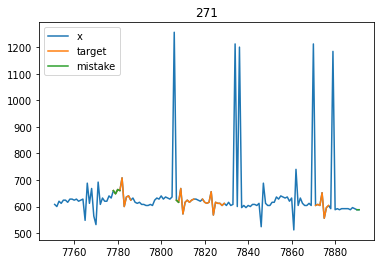

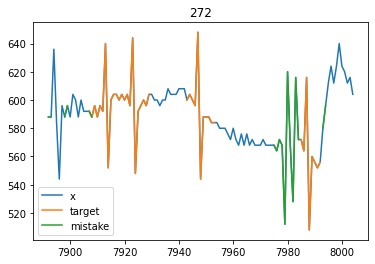

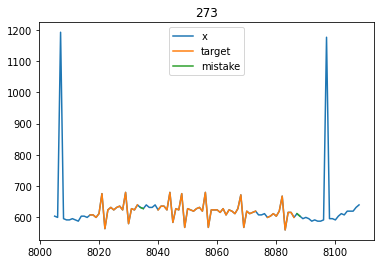

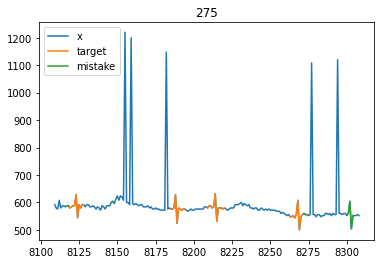

In [197]:
for i in res2.id.unique():
  plt.figure()
  plt.title(i)
  res2[res2.id==i]['x'].plot()
  (res2[res2.id==i]['x'] * res2[res2.id==i]['y'].replace(0, np.nan)).plot(label='target')
  (res2[res2.id==i]['x']* res2[res2.id==i]['mistake'].replace(0, np.nan)).plot(label='mistake')
  plt.legend()